<h1>contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#tl;dr" data-toc-modified-id="tl;dr-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>tl;dr</a></span></li><li><span><a href="#setup" data-toc-modified-id="setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>setup</a></span></li><li><span><a href="#neural-network-architecture" data-toc-modified-id="neural-network-architecture-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>neural network architecture</a></span></li><li><span><a href="#data" data-toc-modified-id="data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>data</a></span></li><li><span><a href="#training" data-toc-modified-id="training-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>training</a></span></li><li><span><a href="#results" data-toc-modified-id="results-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>results</a></span></li></ul></div>

# tl;dr

In this notebook we will try to make some experiments with the **Driven Harmonic Oscillator** (DHO) synthetic data. We try to learn the intensity $F_0$ of sinonoidal driven force in $$m\ddot{x} + c\dot{x} + kx = F_0\cos(\omega t + \phi_d)$$

# setup

In [2]:
import os
# import pprint
# import functools
import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

import torch
import torch.nn as nn
import torch.optim as optim

# import optuna

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from IPython.display import display

%matplotlib inline

In [3]:
mpl.rcParams['font.family'] = 'serif'
# mpl.rcParams['text.usetex'] = True

experiment_name = "dho_parameter_learning"

folder_path = f"../data/08_reporting/{experiment_name}"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

golden_ratio = (np.sqrt(5) - 1) / 2

# neural network architecture

In [6]:
class MultiLayerPerceptronRegressor(nn.Module):
    """
    feedforward neural network regressor
    """
    def __init__(self, layers:list, activation:torch.nn.modules.activation):
        super(MultiLayerPerceptronRegressor, self).__init__()
        _architecture = list()

        for index, layer in enumerate(layers[:-2]):
            _architecture.append(nn.Linear(layer, layers[index+1]))
            # _architecture.append(nn.BatchNorm1d(layers[index+1]))  # Add batch normalization layer
            _architecture.append(activation())
        _architecture.append(nn.Linear(layers[-2], layers[-1]))
        
        self.architecture = nn.Sequential(*_architecture)

    def forward(self, x):
        return self.architecture(x)


$$ \ddot{x} + \frac{\mu}{m} \dot{x} + \frac{k}{m} x = 0 $$

# data

10.0 1 9


,time,displacement
0,4.441679,-1.437988
1,7.748434,5.567860
2,3.775061,0.891907
3,10.328352,-1.244641
4,1.109587,-0.027045


10.0 1 9


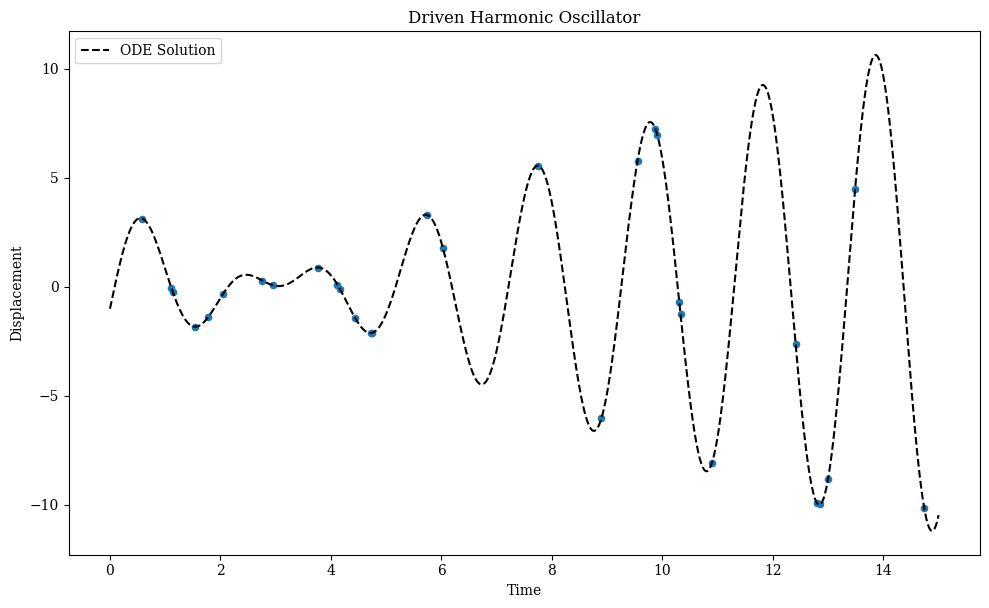

In [136]:

def driven_oscillator(t, m, k, c, w0, w, F0, x0, v0, phid):
    """
    driven_oscillator
    """
    w0 = np.sqrt(k/m)
    gamma = c/2/m
    
    wprime = np.sqrt(w0**2 - gamma**2)
    A = F0 / m / np.sqrt((w0**2 - w**2)**2 + 4 * gamma**2 * w**2 )
    
    print(k, m, w**2)
    phi = np.arctan(c * w / (k - m * w**2)) - phid
    phih = np.arctan(wprime * (x0 - A * np.cos(phi)) \
        / (v0 + gamma * (x0 - A * np.cos(phi)) - A * w * np.sin(phi) ) )
    
    Ah = (x0 - A * np.cos(phi)) / np.sin(phih)
    
    x = Ah * np.exp(-gamma * t) * np.sin(wprime * t + phih) + A * np.cos(w * t - phi)
    
    return x

torch.manual_seed(123)

d, w0 = 0.5, 20
m = 1
k = 1e1
c = 0.05
w = 3
F0 = 7.89
x0 = -1
v0 = 12
phid = np.pi

x = torch.rand(30)*15
y = driven_oscillator(x, m, k, c, w0, w, F0, x0, v0, phid)

X = pd.DataFrame({"time": x.squeeze(), "displacement": y.squeeze()})
X.to_parquet(f"{folder_path}/synthetic_data.parquet")

display(X.head())

fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(10, golden_ratio*10))

t = np.linspace(0, 15, 1000)
X.plot.scatter(x="time", y="displacement", ax=ax1)
ax1.plot(t, driven_oscillator(t, m, k, c, w0, w, F0, x0, v0, phid), label="ODE Solution", c="k", linestyle="--",)

ax1.set_xlabel("Time")
ax1.set_ylabel("Displacement")
ax1.set_title("Driven Harmonic Oscillator")
ax1.legend()

plt.tight_layout()
plt.savefig(f"{folder_path}/displacement_vs_time.png", dpi=300)

# training

In [7]:
time_threshold = 15

MultiLayerPerceptronRegressor(
  (architecture): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=64, out_features=64, bias=True)
    (9): ELU(alpha=1.0)
    (10): Linear(in_features=64, out_features=1, bias=True)
  )
)
10.0 1 9


  0%|          | 0/200000 [00:00<?, ?it/s]

  1%|          | 1045/200000 [00:03<10:42, 309.51it/s]

F0:  10.0
Data Loss: 0.621633, Physics Loss: 0.000000, x0 Loss: 0.000000, v0 Loss: 0.000000, Total Loss: 0.621633


  1%|          | 2053/200000 [00:06<10:16, 321.16it/s]

F0:  10.0
Data Loss: 0.110596, Physics Loss: 0.000000, x0 Loss: 0.000000, v0 Loss: 0.000000, Total Loss: 0.110596


  2%|▏         | 3082/200000 [00:09<07:41, 426.50it/s]

F0:  10.0
Data Loss: 1.401322, Physics Loss: 0.000000, x0 Loss: 0.000000, v0 Loss: 0.000000, Total Loss: 1.401322


  2%|▏         | 4065/200000 [00:12<08:34, 381.08it/s]

F0:  10.0
Data Loss: 0.038738, Physics Loss: 0.000000, x0 Loss: 0.000000, v0 Loss: 0.000000, Total Loss: 0.038738


  3%|▎         | 5030/200000 [00:15<09:50, 330.14it/s]

F0:  10.0
Data Loss: 0.023304, Physics Loss: 0.000000, x0 Loss: 0.000000, v0 Loss: 0.000000, Total Loss: 0.023304


  3%|▎         | 6041/200000 [00:18<09:11, 351.74it/s]

F0:  10.0
Data Loss: 0.016349, Physics Loss: 0.000000, x0 Loss: 0.000000, v0 Loss: 0.000000, Total Loss: 0.016349


  4%|▎         | 7051/200000 [00:21<07:38, 420.58it/s]

F0:  10.0
Data Loss: 0.013876, Physics Loss: 0.000000, x0 Loss: 0.000000, v0 Loss: 0.000000, Total Loss: 0.013876


  4%|▍         | 8020/200000 [00:25<16:10, 197.91it/s]

F0:  9.794747352600098
Data Loss: 8.264570, Physics Loss: 1241.567993, x0 Loss: 52.115902, v0 Loss: 73.777618, Total Loss: 8.401317


  5%|▍         | 9029/200000 [00:30<18:08, 175.38it/s]

F0:  9.384317398071289
Data Loss: 1.244598, Physics Loss: 1406.117920, x0 Loss: 16.137249, v0 Loss: 1.637723, Total Loss: 1.386987


  5%|▌         | 10019/200000 [00:35<16:00, 197.84it/s]

F0:  9.21921443939209
Data Loss: 1.014828, Physics Loss: 1232.375000, x0 Loss: 8.726978, v0 Loss: 0.310530, Total Loss: 1.138970


  6%|▌         | 11026/200000 [00:40<14:57, 210.47it/s]

F0:  9.080705642700195
Data Loss: 1.333991, Physics Loss: 1043.270264, x0 Loss: 6.702925, v0 Loss: 0.759579, Total Loss: 1.439064


  6%|▌         | 12020/200000 [00:46<18:28, 169.53it/s]

F0:  9.236929893493652
Data Loss: 0.630437, Physics Loss: 982.872498, x0 Loss: 5.535279, v0 Loss: 0.376124, Total Loss: 0.729315


  7%|▋         | 13036/200000 [00:51<15:10, 205.26it/s]

F0:  9.176199913024902
Data Loss: 0.211764, Physics Loss: 842.222656, x0 Loss: 4.440956, v0 Loss: 0.988353, Total Loss: 0.296529


  7%|▋         | 14026/200000 [00:57<18:03, 171.60it/s]

F0:  8.888922691345215
Data Loss: 2.361832, Physics Loss: 2217.219238, x0 Loss: 3.898631, v0 Loss: 0.004614, Total Loss: 2.583945


  8%|▊         | 15019/200000 [01:02<17:49, 172.94it/s]

F0:  8.404891014099121
Data Loss: 0.050477, Physics Loss: 685.982300, x0 Loss: 3.614750, v0 Loss: 0.033255, Total Loss: 0.119440


  8%|▊         | 16025/200000 [01:08<16:00, 191.51it/s]

F0:  8.040310859680176
Data Loss: 0.055285, Physics Loss: 537.512024, x0 Loss: 2.713882, v0 Loss: 0.136932, Total Loss: 0.109321


  9%|▊         | 17031/200000 [01:13<16:01, 190.35it/s]

F0:  8.232915878295898
Data Loss: 0.659650, Physics Loss: 1277.763062, x0 Loss: 2.013488, v0 Loss: 6.099813, Total Loss: 0.788237


  9%|▉         | 18023/200000 [01:19<16:57, 178.79it/s]

F0:  8.708578109741211
Data Loss: 0.063047, Physics Loss: 1099.126831, x0 Loss: 1.880036, v0 Loss: 0.323403, Total Loss: 0.173180


 10%|▉         | 19041/200000 [01:24<14:42, 205.00it/s]

F0:  8.941967964172363
Data Loss: 0.020423, Physics Loss: 997.422424, x0 Loss: 0.531546, v0 Loss: 0.039117, Total Loss: 0.120222


 10%|█         | 20028/200000 [01:29<16:32, 181.37it/s]

F0:  9.051012992858887
Data Loss: 1.114725, Physics Loss: 1103.401245, x0 Loss: 0.042341, v0 Loss: 2.868416, Total Loss: 1.225356


 11%|█         | 21023/200000 [01:35<18:14, 163.57it/s]

F0:  8.976290702819824
Data Loss: 0.159843, Physics Loss: 887.769348, x0 Loss: 0.222909, v0 Loss: 0.002538, Total Loss: 0.248642


 11%|█         | 22030/200000 [01:41<15:24, 192.47it/s]

F0:  8.851554870605469
Data Loss: 0.525834, Physics Loss: 806.136719, x0 Loss: 0.449036, v0 Loss: 0.036382, Total Loss: 0.606496


 12%|█▏        | 23039/200000 [01:46<15:02, 196.07it/s]

F0:  8.338960647583008
Data Loss: 4.122439, Physics Loss: 1725.072144, x0 Loss: 0.087997, v0 Loss: 0.011080, Total Loss: 4.294957


 12%|█▏        | 24016/200000 [01:52<18:16, 160.46it/s]

F0:  7.90559196472168
Data Loss: 1.653653, Physics Loss: 1112.912842, x0 Loss: 0.177515, v0 Loss: 0.000511, Total Loss: 1.764962


 13%|█▎        | 25034/200000 [01:57<14:53, 195.83it/s]

F0:  7.336519241333008
Data Loss: 0.699119, Physics Loss: 1199.654175, x0 Loss: 0.000234, v0 Loss: 0.003333, Total Loss: 0.819085


 13%|█▎        | 26029/200000 [02:02<14:31, 199.69it/s]

F0:  6.642595291137695
Data Loss: 0.270634, Physics Loss: 1220.878906, x0 Loss: 0.042981, v0 Loss: 0.005605, Total Loss: 0.392726


 14%|█▎        | 27024/200000 [02:07<17:18, 166.62it/s]

F0:  6.098552703857422
Data Loss: 0.135995, Physics Loss: 1131.946045, x0 Loss: 0.104863, v0 Loss: 0.004422, Total Loss: 0.249201


 14%|█▍        | 28033/200000 [02:13<14:15, 201.00it/s]

F0:  5.60070276260376
Data Loss: 0.144939, Physics Loss: 1006.307800, x0 Loss: 0.008146, v0 Loss: 0.003500, Total Loss: 0.245571


 15%|█▍        | 29030/200000 [02:19<15:48, 180.23it/s]

F0:  5.131046295166016
Data Loss: 0.041755, Physics Loss: 981.962097, x0 Loss: 0.000509, v0 Loss: 0.000875, Total Loss: 0.139952


 15%|█▌        | 30033/200000 [02:24<14:17, 198.31it/s]

F0:  4.680048942565918
Data Loss: 0.029041, Physics Loss: 830.079590, x0 Loss: 0.003507, v0 Loss: 0.000579, Total Loss: 0.112049


 16%|█▌        | 31039/200000 [02:30<13:58, 201.59it/s]

F0:  4.247931957244873
Data Loss: 0.073261, Physics Loss: 842.138428, x0 Loss: 0.001280, v0 Loss: 0.000181, Total Loss: 0.157474


 16%|█▌        | 32032/200000 [02:35<14:38, 191.09it/s]

F0:  3.857478380203247
Data Loss: 0.691875, Physics Loss: 793.684998, x0 Loss: 0.000026, v0 Loss: 0.019837, Total Loss: 0.771245


 17%|█▋        | 33019/200000 [02:40<14:44, 188.86it/s]

F0:  3.4468235969543457
Data Loss: 0.128488, Physics Loss: 836.672302, x0 Loss: 0.006999, v0 Loss: 0.055907, Total Loss: 0.212161


 17%|█▋        | 34017/200000 [02:45<16:18, 169.66it/s]

F0:  3.1942427158355713
Data Loss: 0.052160, Physics Loss: 652.762329, x0 Loss: 0.008672, v0 Loss: 0.023093, Total Loss: 0.117439


 18%|█▊        | 35025/200000 [02:51<14:15, 192.83it/s]

F0:  2.8187544345855713
Data Loss: 0.039649, Physics Loss: 631.986572, x0 Loss: 0.002383, v0 Loss: 0.000770, Total Loss: 0.102848


 18%|█▊        | 36022/200000 [02:56<15:35, 175.37it/s]

F0:  2.4661929607391357
Data Loss: 0.058667, Physics Loss: 615.081726, x0 Loss: 0.002846, v0 Loss: 0.002281, Total Loss: 0.120176


 19%|█▊        | 37031/200000 [03:02<15:59, 169.82it/s]

F0:  2.1520285606384277
Data Loss: 0.016752, Physics Loss: 586.816101, x0 Loss: 0.002981, v0 Loss: 0.000128, Total Loss: 0.075434


 19%|█▉        | 38041/200000 [03:08<13:23, 201.68it/s]

F0:  1.922855257987976
Data Loss: 0.041164, Physics Loss: 587.045105, x0 Loss: 0.003784, v0 Loss: 0.000474, Total Loss: 0.099868


 20%|█▉        | 39019/200000 [03:13<14:28, 185.42it/s]

F0:  1.8441914319992065
Data Loss: 0.014004, Physics Loss: 573.500977, x0 Loss: 0.005550, v0 Loss: 0.000142, Total Loss: 0.071355


 20%|██        | 40018/200000 [03:18<13:24, 198.84it/s]

F0:  1.8522156476974487
Data Loss: 0.014131, Physics Loss: 576.072815, x0 Loss: 0.001685, v0 Loss: 0.000000, Total Loss: 0.071738


 21%|██        | 41025/200000 [03:24<14:22, 184.41it/s]

F0:  1.758771538734436
Data Loss: 0.055502, Physics Loss: 548.641968, x0 Loss: 0.000716, v0 Loss: 0.002480, Total Loss: 0.110367


 21%|██        | 42036/200000 [03:29<13:28, 195.31it/s]

F0:  1.810185432434082
Data Loss: 0.013201, Physics Loss: 541.927673, x0 Loss: 0.000150, v0 Loss: 0.000177, Total Loss: 0.067393


 22%|██▏       | 43024/200000 [03:34<13:19, 196.38it/s]

F0:  2.0823965072631836
Data Loss: 0.037456, Physics Loss: 553.533752, x0 Loss: 0.000114, v0 Loss: 0.000036, Total Loss: 0.092809


 22%|██▏       | 44021/200000 [03:40<12:25, 209.36it/s]

F0:  2.338493824005127
Data Loss: 0.012094, Physics Loss: 524.908325, x0 Loss: 0.000282, v0 Loss: 0.000000, Total Loss: 0.064585


 23%|██▎       | 45031/200000 [03:45<14:41, 175.79it/s]

F0:  2.6677682399749756
Data Loss: 0.011405, Physics Loss: 503.447632, x0 Loss: 0.117035, v0 Loss: 0.000730, Total Loss: 0.061762


 23%|██▎       | 46019/200000 [03:51<14:41, 174.61it/s]

F0:  2.9376230239868164
Data Loss: 0.021329, Physics Loss: 517.728943, x0 Loss: 0.009078, v0 Loss: 0.000119, Total Loss: 0.073102


 24%|██▎       | 47030/200000 [03:56<12:32, 203.16it/s]

F0:  3.179558753967285
Data Loss: 0.016279, Physics Loss: 500.779205, x0 Loss: 0.030806, v0 Loss: 0.000082, Total Loss: 0.066360


 24%|██▍       | 48029/200000 [04:02<14:51, 170.51it/s]

F0:  3.473259925842285
Data Loss: 0.478708, Physics Loss: 569.920349, x0 Loss: 0.003930, v0 Loss: 0.005605, Total Loss: 0.535701


 25%|██▍       | 49025/200000 [04:07<13:40, 184.08it/s]

F0:  3.7550034523010254
Data Loss: 0.018113, Physics Loss: 518.211731, x0 Loss: 0.019663, v0 Loss: 0.000398, Total Loss: 0.069936


 25%|██▌       | 50028/200000 [04:13<14:44, 169.60it/s]

F0:  4.245792388916016
Data Loss: 0.011917, Physics Loss: 504.636627, x0 Loss: 0.000003, v0 Loss: 0.000335, Total Loss: 0.062381


 26%|██▌       | 51026/200000 [04:19<14:43, 168.59it/s]

F0:  4.636687278747559
Data Loss: 0.018507, Physics Loss: 486.332581, x0 Loss: 0.000332, v0 Loss: 0.002187, Total Loss: 0.067141


 26%|██▌       | 52021/200000 [04:24<13:02, 189.14it/s]

F0:  4.944438934326172
Data Loss: 0.043113, Physics Loss: 480.048340, x0 Loss: 0.000013, v0 Loss: 0.000856, Total Loss: 0.091118


 27%|██▋       | 53025/200000 [04:30<13:04, 187.25it/s]

F0:  5.234220504760742
Data Loss: 0.021408, Physics Loss: 477.441864, x0 Loss: 0.638773, v0 Loss: 0.000904, Total Loss: 0.069216


 27%|██▋       | 54024/200000 [04:36<15:13, 159.85it/s]

F0:  5.556413650512695
Data Loss: 0.079626, Physics Loss: 534.320984, x0 Loss: 0.119927, v0 Loss: 0.002995, Total Loss: 0.133070


 28%|██▊       | 55033/200000 [04:42<13:47, 175.10it/s]

F0:  5.868973255157471
Data Loss: 0.007674, Physics Loss: 463.139282, x0 Loss: 0.110067, v0 Loss: 0.001879, Total Loss: 0.053999


 28%|██▊       | 56022/200000 [04:47<13:57, 172.01it/s]

F0:  6.264376640319824
Data Loss: 0.007469, Physics Loss: 527.962891, x0 Loss: 0.153888, v0 Loss: 0.001040, Total Loss: 0.060281


 29%|██▊       | 57032/200000 [04:53<13:03, 182.38it/s]

F0:  6.839818000793457
Data Loss: 0.008497, Physics Loss: 487.388550, x0 Loss: 0.016775, v0 Loss: 0.000730, Total Loss: 0.057238


 29%|██▉       | 58018/200000 [04:59<13:31, 174.87it/s]

F0:  7.2716965675354
Data Loss: 0.007351, Physics Loss: 474.274628, x0 Loss: 0.992381, v0 Loss: 0.000012, Total Loss: 0.054878


 30%|██▉       | 59022/200000 [05:05<13:50, 169.65it/s]

F0:  7.646546363830566
Data Loss: 0.006498, Physics Loss: 461.732086, x0 Loss: 0.376612, v0 Loss: 0.006705, Total Loss: 0.052710


 30%|███       | 60033/200000 [05:10<12:20, 188.90it/s]

F0:  8.003373146057129
Data Loss: 0.013146, Physics Loss: 444.593048, x0 Loss: 0.185299, v0 Loss: 0.006243, Total Loss: 0.057625


 31%|███       | 61033/200000 [05:16<14:00, 165.32it/s]

F0:  8.305980682373047
Data Loss: 0.023687, Physics Loss: 450.085297, x0 Loss: 0.127193, v0 Loss: 0.001300, Total Loss: 0.068708


 31%|███       | 62034/200000 [05:22<11:40, 197.00it/s]

F0:  8.63133430480957
Data Loss: 0.007598, Physics Loss: 482.088745, x0 Loss: 0.036748, v0 Loss: 0.000403, Total Loss: 0.055811


 32%|███▏      | 63024/200000 [05:27<11:43, 194.71it/s]

F0:  8.886395454406738
Data Loss: 0.007020, Physics Loss: 457.201904, x0 Loss: 0.010670, v0 Loss: 0.000274, Total Loss: 0.052741


 32%|███▏      | 64022/200000 [05:33<13:39, 165.88it/s]

F0:  9.115924835205078
Data Loss: 0.419796, Physics Loss: 916.285278, x0 Loss: 0.830484, v0 Loss: 0.027473, Total Loss: 0.511510


 33%|███▎      | 65030/200000 [05:38<13:25, 167.65it/s]

F0:  9.352387428283691
Data Loss: 0.005351, Physics Loss: 364.280426, x0 Loss: 0.021377, v0 Loss: 0.000066, Total Loss: 0.041781


 33%|███▎      | 66032/200000 [05:45<13:34, 164.55it/s]

F0:  9.713126182556152
Data Loss: 0.005548, Physics Loss: 311.375214, x0 Loss: 0.009880, v0 Loss: 0.000401, Total Loss: 0.036687


 34%|███▎      | 67028/200000 [05:50<11:16, 196.43it/s]

F0:  10.156356811523438
Data Loss: 0.001705, Physics Loss: 295.116699, x0 Loss: 0.009463, v0 Loss: 0.000241, Total Loss: 0.031218


 34%|███▍      | 68029/200000 [05:56<13:28, 163.29it/s]

F0:  10.632072448730469
Data Loss: 0.088677, Physics Loss: 290.255096, x0 Loss: 0.006813, v0 Loss: 0.002063, Total Loss: 0.117703


 35%|███▍      | 69021/200000 [06:02<11:09, 195.69it/s]

F0:  11.05992317199707
Data Loss: 0.017823, Physics Loss: 295.725891, x0 Loss: 0.448916, v0 Loss: 0.009422, Total Loss: 0.047441


 35%|███▌      | 70029/200000 [06:08<10:47, 200.82it/s]

F0:  11.443939208984375
Data Loss: 0.001470, Physics Loss: 291.017181, x0 Loss: 0.052219, v0 Loss: 0.000117, Total Loss: 0.030577


 36%|███▌      | 71025/200000 [06:13<12:12, 176.10it/s]

F0:  11.762285232543945
Data Loss: 0.084584, Physics Loss: 318.494354, x0 Loss: 0.000012, v0 Loss: 0.005635, Total Loss: 0.116434


 36%|███▌      | 72019/200000 [06:19<12:01, 177.31it/s]

F0:  12.097176551818848
Data Loss: 0.063987, Physics Loss: 1219.743042, x0 Loss: 0.000449, v0 Loss: 0.001483, Total Loss: 0.185961


 37%|███▋      | 73030/200000 [06:24<10:09, 208.38it/s]

F0:  12.552717208862305
Data Loss: 0.008449, Physics Loss: 1107.491943, x0 Loss: 0.000239, v0 Loss: 0.000006, Total Loss: 0.119199


 37%|███▋      | 74024/200000 [06:29<13:17, 157.98it/s]

F0:  12.962186813354492
Data Loss: 0.007141, Physics Loss: 1077.136108, x0 Loss: 0.002291, v0 Loss: 0.001068, Total Loss: 0.114855


 38%|███▊      | 75028/200000 [06:35<10:08, 205.41it/s]

F0:  13.313279151916504
Data Loss: 0.006233, Physics Loss: 1091.088135, x0 Loss: 0.000005, v0 Loss: 0.000037, Total Loss: 0.115342


 38%|███▊      | 76030/200000 [06:40<11:05, 186.15it/s]

F0:  13.661576271057129
Data Loss: 0.012049, Physics Loss: 1066.701172, x0 Loss: 0.002688, v0 Loss: 0.000521, Total Loss: 0.118720


 39%|███▊      | 77023/200000 [06:45<11:47, 173.76it/s]

F0:  14.023780822753906
Data Loss: 0.005455, Physics Loss: 1005.112976, x0 Loss: 0.000210, v0 Loss: 0.000000, Total Loss: 0.105967


 39%|███▉      | 78021/200000 [06:51<10:19, 197.02it/s]

F0:  13.844693183898926
Data Loss: 0.004471, Physics Loss: 645.755554, x0 Loss: 0.000012, v0 Loss: 0.000056, Total Loss: 0.069047


 40%|███▉      | 79031/200000 [06:56<10:28, 192.49it/s]

F0:  13.159748077392578
Data Loss: 0.004059, Physics Loss: 556.978577, x0 Loss: 0.011831, v0 Loss: 0.000066, Total Loss: 0.059758


 40%|████      | 80021/200000 [07:02<11:27, 174.56it/s]

F0:  12.628379821777344
Data Loss: 0.004928, Physics Loss: 524.889832, x0 Loss: 0.005309, v0 Loss: 0.000169, Total Loss: 0.057418


 41%|████      | 81023/200000 [07:07<12:12, 162.43it/s]

F0:  12.151123046875
Data Loss: 0.003583, Physics Loss: 435.411469, x0 Loss: 0.000017, v0 Loss: 0.000014, Total Loss: 0.047124


 41%|████      | 82028/200000 [07:13<11:46, 167.01it/s]

F0:  12.617976188659668
Data Loss: 0.008256, Physics Loss: 1188.049316, x0 Loss: 0.000334, v0 Loss: 0.000001, Total Loss: 0.127061


 42%|████▏     | 83024/200000 [07:19<09:06, 214.15it/s]

F0:  13.157242774963379
Data Loss: 0.099470, Physics Loss: 1239.052368, x0 Loss: 0.000099, v0 Loss: 0.000635, Total Loss: 0.223375


 42%|████▏     | 84023/200000 [07:24<12:06, 159.54it/s]

F0:  13.461297035217285
Data Loss: 0.061605, Physics Loss: 746.244995, x0 Loss: 0.001077, v0 Loss: 0.013975, Total Loss: 0.136231


 43%|████▎     | 85022/200000 [07:29<10:00, 191.47it/s]

F0:  13.662964820861816
Data Loss: 0.006858, Physics Loss: 660.180664, x0 Loss: 0.411939, v0 Loss: 0.000920, Total Loss: 0.072917


 43%|████▎     | 86033/200000 [07:35<11:13, 169.15it/s]

F0:  13.835489273071289
Data Loss: 0.021005, Physics Loss: 614.383728, x0 Loss: 0.000037, v0 Loss: 0.000619, Total Loss: 0.082444


 44%|████▎     | 87036/200000 [07:41<10:13, 184.13it/s]

F0:  14.027702331542969
Data Loss: 0.006387, Physics Loss: 579.166626, x0 Loss: 0.000199, v0 Loss: 0.000018, Total Loss: 0.064303


 44%|████▍     | 88023/200000 [07:46<10:38, 175.49it/s]

F0:  14.23226547241211
Data Loss: 0.006907, Physics Loss: 613.865784, x0 Loss: 0.000575, v0 Loss: 7.801655, Total Loss: 0.069074


 45%|████▍     | 89034/200000 [07:51<10:36, 174.32it/s]

F0:  14.115124702453613
Data Loss: 0.009813, Physics Loss: 508.977417, x0 Loss: 0.005977, v0 Loss: 0.000235, Total Loss: 0.060711


 45%|████▌     | 90023/200000 [07:56<10:28, 174.92it/s]

F0:  14.016829490661621
Data Loss: 0.013846, Physics Loss: 458.716705, x0 Loss: 0.002350, v0 Loss: 0.000928, Total Loss: 0.059718


 46%|████▌     | 91029/200000 [08:02<10:22, 175.00it/s]

F0:  13.996393203735352
Data Loss: 0.027721, Physics Loss: 439.689484, x0 Loss: 0.002024, v0 Loss: 0.002020, Total Loss: 0.071691


 46%|████▌     | 92024/200000 [08:08<11:11, 160.87it/s]

F0:  13.944405555725098
Data Loss: 0.098028, Physics Loss: 1542.839355, x0 Loss: 0.351799, v0 Loss: 0.124277, Total Loss: 0.252359


 47%|████▋     | 93020/200000 [08:13<10:24, 171.19it/s]

F0:  14.555220603942871
Data Loss: 0.004713, Physics Loss: 688.095398, x0 Loss: 0.000664, v0 Loss: 0.082897, Total Loss: 0.073531


 47%|████▋     | 94031/200000 [08:19<09:57, 177.23it/s]

F0:  14.756688117980957
Data Loss: 0.002721, Physics Loss: 635.132263, x0 Loss: 0.006056, v0 Loss: 0.000171, Total Loss: 0.066235


 48%|████▊     | 95036/200000 [08:24<09:07, 191.61it/s]

F0:  14.719827651977539
Data Loss: 0.002222, Physics Loss: 541.319336, x0 Loss: 0.000185, v0 Loss: 0.000128, Total Loss: 0.056354


 48%|████▊     | 96030/200000 [08:30<08:27, 204.92it/s]

F0:  14.345355033874512
Data Loss: 0.001831, Physics Loss: 422.529755, x0 Loss: 0.000004, v0 Loss: 0.000058, Total Loss: 0.044084


 49%|████▊     | 97031/200000 [08:35<10:38, 161.23it/s]

F0:  13.986531257629395
Data Loss: 0.002627, Physics Loss: 411.369598, x0 Loss: 0.001676, v0 Loss: 0.000000, Total Loss: 0.043764


 49%|████▉     | 98025/200000 [08:41<08:28, 200.54it/s]

F0:  13.694845199584961
Data Loss: 0.001532, Physics Loss: 405.596802, x0 Loss: 0.000793, v0 Loss: 0.000381, Total Loss: 0.042092


 50%|████▉     | 99022/200000 [08:46<09:59, 168.42it/s]

F0:  13.498358726501465
Data Loss: 0.065440, Physics Loss: 386.084412, x0 Loss: 0.001996, v0 Loss: 0.000971, Total Loss: 0.104049


 50%|█████     | 100026/200000 [08:52<09:26, 176.34it/s]

F0:  13.342676162719727
Data Loss: 0.001550, Physics Loss: 384.506256, x0 Loss: 0.000935, v0 Loss: 0.000168, Total Loss: 0.040001


 51%|█████     | 101022/200000 [08:58<09:14, 178.51it/s]

F0:  13.16698169708252
Data Loss: 0.007225, Physics Loss: 379.307190, x0 Loss: 0.000169, v0 Loss: 0.000155, Total Loss: 0.045156


 51%|█████     | 102019/200000 [09:04<09:25, 173.23it/s]

F0:  13.09850025177002
Data Loss: 0.003639, Physics Loss: 363.602539, x0 Loss: 0.005335, v0 Loss: 0.000596, Total Loss: 0.040000


 52%|█████▏    | 103020/200000 [09:10<10:09, 159.20it/s]

F0:  13.031124114990234
Data Loss: 0.001784, Physics Loss: 358.367126, x0 Loss: 0.001420, v0 Loss: 0.000077, Total Loss: 0.037620


 52%|█████▏    | 104022/200000 [09:15<09:35, 166.91it/s]

F0:  12.951552391052246
Data Loss: 1.594471, Physics Loss: 2015.051514, x0 Loss: 0.378413, v0 Loss: 0.007160, Total Loss: 1.796015


 53%|█████▎    | 105032/200000 [09:20<08:22, 188.84it/s]

F0:  13.701579093933105
Data Loss: 0.002058, Physics Loss: 855.484253, x0 Loss: 0.020473, v0 Loss: 0.000087, Total Loss: 0.087608


 53%|█████▎    | 106039/200000 [09:25<08:06, 193.07it/s]

F0:  14.219378471374512
Data Loss: 0.160845, Physics Loss: 664.469177, x0 Loss: 0.040018, v0 Loss: 0.000047, Total Loss: 0.227296


 54%|█████▎    | 107038/200000 [09:30<07:52, 196.81it/s]

F0:  14.076248168945312
Data Loss: 0.002272, Physics Loss: 341.169281, x0 Loss: 0.000515, v0 Loss: 0.001203, Total Loss: 0.036389


 54%|█████▍    | 108017/200000 [09:36<08:45, 175.16it/s]

F0:  13.854819297790527
Data Loss: 0.245805, Physics Loss: 396.340546, x0 Loss: 0.017993, v0 Loss: 0.005100, Total Loss: 0.285441


 55%|█████▍    | 109031/200000 [09:42<08:22, 181.17it/s]

F0:  13.597077369689941
Data Loss: 2.096890, Physics Loss: 926.360352, x0 Loss: 0.000509, v0 Loss: 0.577202, Total Loss: 2.189584


 55%|█████▌    | 110018/200000 [09:47<08:51, 169.17it/s]

F0:  13.370566368103027
Data Loss: 0.011474, Physics Loss: 329.595062, x0 Loss: 0.000044, v0 Loss: 0.005530, Total Loss: 0.044434


 56%|█████▌    | 111033/200000 [09:53<08:16, 179.06it/s]

F0:  13.207563400268555
Data Loss: 0.001573, Physics Loss: 330.938904, x0 Loss: 0.000266, v0 Loss: 0.000039, Total Loss: 0.034667


 56%|█████▌    | 112029/200000 [09:58<07:27, 196.66it/s]

F0:  13.027606010437012
Data Loss: 0.000698, Physics Loss: 322.565765, x0 Loss: 0.085551, v0 Loss: 0.004383, Total Loss: 0.032964


 57%|█████▋    | 113025/200000 [10:04<08:40, 167.16it/s]

F0:  12.908384323120117
Data Loss: 0.000674, Physics Loss: 327.014221, x0 Loss: 0.000036, v0 Loss: 0.000016, Total Loss: 0.033375


 57%|█████▋    | 114025/200000 [10:09<08:00, 178.80it/s]

F0:  12.77289867401123
Data Loss: 0.002427, Physics Loss: 317.987000, x0 Loss: 0.000780, v0 Loss: 0.000320, Total Loss: 0.034226


 58%|█████▊    | 115018/200000 [10:15<08:25, 168.16it/s]

F0:  12.523755073547363
Data Loss: 0.000649, Physics Loss: 314.701477, x0 Loss: 0.000219, v0 Loss: 0.000007, Total Loss: 0.032119


 58%|█████▊    | 116016/200000 [10:21<08:35, 162.77it/s]

F0:  12.316415786743164
Data Loss: 0.000635, Physics Loss: 310.180511, x0 Loss: 0.000102, v0 Loss: 0.000005, Total Loss: 0.031653


 59%|█████▊    | 117031/200000 [10:27<07:59, 173.05it/s]

F0:  12.136570930480957
Data Loss: 0.001035, Physics Loss: 307.276093, x0 Loss: 0.000308, v0 Loss: 0.000002, Total Loss: 0.031762


 59%|█████▉    | 118017/200000 [10:33<07:50, 174.41it/s]

F0:  12.028825759887695
Data Loss: 0.000610, Physics Loss: 302.774841, x0 Loss: 0.000139, v0 Loss: 0.000335, Total Loss: 0.030887


 60%|█████▉    | 119022/200000 [10:39<08:15, 163.41it/s]

F0:  11.745006561279297
Data Loss: 0.013400, Physics Loss: 312.551056, x0 Loss: 0.000672, v0 Loss: 0.002155, Total Loss: 0.044655


 60%|██████    | 120021/200000 [10:45<08:20, 159.88it/s]

F0:  11.523566246032715
Data Loss: 0.002564, Physics Loss: 309.137756, x0 Loss: 0.000335, v0 Loss: 0.000002, Total Loss: 0.033478


 61%|██████    | 121026/200000 [10:51<07:52, 166.97it/s]

F0:  11.376258850097656
Data Loss: 0.010932, Physics Loss: 303.672791, x0 Loss: 0.004460, v0 Loss: 0.029983, Total Loss: 0.041303


 61%|██████    | 122022/200000 [10:57<07:35, 171.10it/s]

F0:  11.233677864074707
Data Loss: 0.000587, Physics Loss: 296.825684, x0 Loss: 0.000005, v0 Loss: 0.000024, Total Loss: 0.030270


 62%|██████▏   | 123030/200000 [11:03<06:48, 188.49it/s]

F0:  11.0703763961792
Data Loss: 0.000574, Physics Loss: 293.956116, x0 Loss: 0.000080, v0 Loss: 0.000007, Total Loss: 0.029969


 62%|██████▏   | 124034/200000 [11:08<07:11, 176.09it/s]

F0:  10.899031639099121
Data Loss: 0.000598, Physics Loss: 293.853760, x0 Loss: 0.000193, v0 Loss: 0.000022, Total Loss: 0.029984


 63%|██████▎   | 125027/200000 [11:14<07:33, 165.39it/s]

F0:  10.849541664123535
Data Loss: 0.000550, Physics Loss: 267.379639, x0 Loss: 0.000584, v0 Loss: 0.000021, Total Loss: 0.027288


 63%|██████▎   | 126033/200000 [11:20<06:56, 177.38it/s]

F0:  10.882376670837402
Data Loss: 0.000531, Physics Loss: 261.895935, x0 Loss: 0.001717, v0 Loss: 0.000000, Total Loss: 0.026721


 64%|██████▎   | 127027/200000 [11:26<07:37, 159.37it/s]

F0:  10.882532119750977
Data Loss: 0.001094, Physics Loss: 257.284851, x0 Loss: 0.000076, v0 Loss: 0.000681, Total Loss: 0.026823


 64%|██████▍   | 128024/200000 [11:32<07:03, 169.99it/s]

F0:  10.761194229125977
Data Loss: 0.099522, Physics Loss: 267.294952, x0 Loss: 0.000621, v0 Loss: 0.000083, Total Loss: 0.126251


 65%|██████▍   | 129021/200000 [11:38<07:14, 163.54it/s]

F0:  10.861281394958496
Data Loss: 0.000652, Physics Loss: 283.986572, x0 Loss: 0.000574, v0 Loss: 0.000821, Total Loss: 0.029051


 65%|██████▌   | 130029/200000 [11:43<06:59, 166.76it/s]

F0:  11.156161308288574
Data Loss: 0.000594, Physics Loss: 293.206482, x0 Loss: 0.000015, v0 Loss: 0.000037, Total Loss: 0.029914


 66%|██████▌   | 131029/200000 [11:49<06:52, 167.11it/s]

F0:  11.471173286437988
Data Loss: 0.000932, Physics Loss: 285.978394, x0 Loss: 0.000000, v0 Loss: 0.000004, Total Loss: 0.029530


 66%|██████▌   | 132024/200000 [11:55<06:45, 167.51it/s]

F0:  11.743292808532715
Data Loss: 0.001495, Physics Loss: 289.143738, x0 Loss: 0.000003, v0 Loss: 0.000289, Total Loss: 0.030409


 67%|██████▋   | 133028/200000 [12:01<06:51, 162.65it/s]

F0:  11.847192764282227
Data Loss: 0.000558, Physics Loss: 287.199707, x0 Loss: 0.000001, v0 Loss: 0.000033, Total Loss: 0.029278


 67%|██████▋   | 134026/200000 [12:07<06:44, 163.12it/s]

F0:  11.921272277832031
Data Loss: 0.000914, Physics Loss: 281.359406, x0 Loss: 0.000081, v0 Loss: 0.000014, Total Loss: 0.029050


 68%|██████▊   | 135019/200000 [12:13<06:30, 166.31it/s]

F0:  12.042790412902832
Data Loss: 0.096930, Physics Loss: 500.222961, x0 Loss: 0.003674, v0 Loss: 0.027485, Total Loss: 0.146955


 68%|██████▊   | 136029/200000 [12:19<06:07, 174.23it/s]

F0:  12.54234790802002
Data Loss: 0.012602, Physics Loss: 715.039062, x0 Loss: 0.001933, v0 Loss: 0.000188, Total Loss: 0.084106


 69%|██████▊   | 137030/200000 [12:25<06:27, 162.54it/s]

F0:  12.68776798248291
Data Loss: 0.001342, Physics Loss: 586.091553, x0 Loss: 0.000000, v0 Loss: 0.000000, Total Loss: 0.059951


 69%|██████▉   | 138031/200000 [12:31<06:03, 170.44it/s]

F0:  12.48680305480957
Data Loss: 0.000942, Physics Loss: 358.432220, x0 Loss: 0.001451, v0 Loss: 0.000234, Total Loss: 0.036786


 70%|██████▉   | 139025/200000 [12:37<05:45, 176.69it/s]

F0:  12.226461410522461
Data Loss: 0.001618, Physics Loss: 574.988586, x0 Loss: 0.002589, v0 Loss: 0.000055, Total Loss: 0.059117


 70%|███████   | 140023/200000 [12:42<05:50, 171.00it/s]

F0:  11.813241004943848
Data Loss: 0.004028, Physics Loss: 250.050598, x0 Loss: 0.002513, v0 Loss: 0.000002, Total Loss: 0.029033


 71%|███████   | 141022/200000 [12:48<06:12, 158.42it/s]

F0:  11.35483169555664
Data Loss: 0.016006, Physics Loss: 248.872940, x0 Loss: 0.000004, v0 Loss: 0.000018, Total Loss: 0.040893


 71%|███████   | 142024/200000 [12:54<05:37, 172.00it/s]

F0:  10.966111183166504
Data Loss: 0.004870, Physics Loss: 294.579926, x0 Loss: 0.028892, v0 Loss: 0.132842, Total Loss: 0.034344


 72%|███████▏  | 143028/200000 [13:00<05:38, 168.44it/s]

F0:  10.60153865814209
Data Loss: 0.028979, Physics Loss: 285.150452, x0 Loss: 0.101639, v0 Loss: 0.000242, Total Loss: 0.057504


 72%|███████▏  | 144032/200000 [13:06<04:58, 187.51it/s]

F0:  10.202239036560059
Data Loss: 0.005869, Physics Loss: 239.756638, x0 Loss: 0.020224, v0 Loss: 0.001277, Total Loss: 0.029846


 73%|███████▎  | 145017/200000 [13:11<05:17, 173.21it/s]

F0:  9.79116439819336
Data Loss: 0.006472, Physics Loss: 222.001389, x0 Loss: 0.000536, v0 Loss: 0.004865, Total Loss: 0.028673


 73%|███████▎  | 146037/200000 [13:17<04:32, 198.12it/s]

F0:  9.428730010986328
Data Loss: 0.005969, Physics Loss: 210.210968, x0 Loss: 0.000000, v0 Loss: 0.000997, Total Loss: 0.026990


 74%|███████▎  | 147032/200000 [13:22<05:07, 172.33it/s]

F0:  9.048002243041992
Data Loss: 0.000888, Physics Loss: 235.547989, x0 Loss: 0.000005, v0 Loss: 0.000017, Total Loss: 0.024443


 74%|███████▍  | 148027/200000 [13:28<04:57, 174.98it/s]

F0:  8.62900447845459
Data Loss: 0.008365, Physics Loss: 216.797958, x0 Loss: 0.000005, v0 Loss: 0.000530, Total Loss: 0.030045


 75%|███████▍  | 149022/200000 [13:34<05:01, 168.90it/s]

F0:  8.301814079284668
Data Loss: 0.000969, Physics Loss: 251.202423, x0 Loss: 0.000009, v0 Loss: 0.000082, Total Loss: 0.026089


 75%|███████▌  | 150017/200000 [13:40<04:49, 172.59it/s]

F0:  7.963416576385498
Data Loss: 0.000873, Physics Loss: 202.873215, x0 Loss: 0.000006, v0 Loss: 0.000010, Total Loss: 0.021160


 76%|███████▌  | 151025/200000 [13:45<04:21, 187.42it/s]

F0:  7.898585796356201
Data Loss: 0.002138, Physics Loss: 225.100998, x0 Loss: 0.000024, v0 Loss: 0.000000, Total Loss: 0.024648


 76%|███████▌  | 152026/200000 [13:51<04:54, 162.98it/s]

F0:  8.015846252441406
Data Loss: 0.049454, Physics Loss: 233.023544, x0 Loss: 0.001786, v0 Loss: 0.001668, Total Loss: 0.072757


 77%|███████▋  | 153023/200000 [13:56<03:48, 205.84it/s]

F0:  8.101649284362793
Data Loss: 0.003920, Physics Loss: 220.595535, x0 Loss: 0.074331, v0 Loss: 0.012022, Total Loss: 0.025989


 77%|███████▋  | 154025/200000 [14:01<04:13, 181.21it/s]

F0:  8.189613342285156
Data Loss: 0.003039, Physics Loss: 225.751297, x0 Loss: 0.003952, v0 Loss: 0.003322, Total Loss: 0.025615


 78%|███████▊  | 155009/200000 [14:07<04:04, 183.65it/s]

F0:  8.618538856506348
Data Loss: 0.000732, Physics Loss: 405.601562, x0 Loss: 0.002039, v0 Loss: 0.000197, Total Loss: 0.041292


 78%|███████▊  | 156023/200000 [14:13<04:19, 169.53it/s]

F0:  8.804550170898438
Data Loss: 0.004706, Physics Loss: 247.787430, x0 Loss: 0.000005, v0 Loss: 0.000000, Total Loss: 0.029484


 79%|███████▊  | 157022/200000 [14:18<04:23, 163.25it/s]

F0:  9.151604652404785
Data Loss: 0.000578, Physics Loss: 290.436554, x0 Loss: 0.000620, v0 Loss: 0.000032, Total Loss: 0.029622


 79%|███████▉  | 158020/200000 [14:25<04:21, 160.65it/s]

F0:  9.070833206176758
Data Loss: 0.000537, Physics Loss: 294.519012, x0 Loss: 0.003875, v0 Loss: 0.000113, Total Loss: 0.029990


 80%|███████▉  | 159029/200000 [14:31<04:06, 166.19it/s]

F0:  9.101395606994629
Data Loss: 0.002204, Physics Loss: 288.269714, x0 Loss: 0.000032, v0 Loss: 0.000168, Total Loss: 0.031031


 80%|████████  | 160033/200000 [14:37<03:48, 175.12it/s]

F0:  9.264867782592773
Data Loss: 0.001637, Physics Loss: 267.168121, x0 Loss: 0.000023, v0 Loss: 0.000085, Total Loss: 0.028353


 81%|████████  | 161025/200000 [14:43<03:32, 183.37it/s]

F0:  9.529964447021484
Data Loss: 0.016778, Physics Loss: 264.081543, x0 Loss: 0.000092, v0 Loss: 0.000272, Total Loss: 0.043186


 81%|████████  | 162029/200000 [14:49<03:46, 167.60it/s]

F0:  9.74731159210205
Data Loss: 0.008797, Physics Loss: 251.123291, x0 Loss: 0.000126, v0 Loss: 0.000766, Total Loss: 0.033909


 82%|████████▏ | 163029/200000 [14:54<03:39, 168.12it/s]

F0:  9.885345458984375
Data Loss: 0.001243, Physics Loss: 248.499374, x0 Loss: 0.005457, v0 Loss: 0.000368, Total Loss: 0.026093


 82%|████████▏ | 164026/200000 [15:00<03:27, 173.30it/s]

F0:  10.049867630004883
Data Loss: 0.000848, Physics Loss: 248.629150, x0 Loss: 0.000001, v0 Loss: 0.000014, Total Loss: 0.025711


 83%|████████▎ | 165023/200000 [15:06<03:32, 164.39it/s]

F0:  10.143357276916504
Data Loss: 0.001740, Physics Loss: 243.315964, x0 Loss: 0.000003, v0 Loss: 0.000003, Total Loss: 0.026071


 83%|████████▎ | 166022/200000 [15:11<03:01, 187.59it/s]

F0:  10.057699203491211
Data Loss: 0.000760, Physics Loss: 274.661591, x0 Loss: 0.000019, v0 Loss: 0.000037, Total Loss: 0.028226


 84%|████████▎ | 167020/200000 [15:16<02:55, 188.35it/s]

F0:  10.065225601196289
Data Loss: 0.002975, Physics Loss: 279.618591, x0 Loss: 0.000029, v0 Loss: 0.000016, Total Loss: 0.030937


 84%|████████▍ | 168026/200000 [15:22<02:41, 197.72it/s]

F0:  10.46701431274414
Data Loss: 0.001344, Physics Loss: 778.693787, x0 Loss: 0.000616, v0 Loss: 0.000007, Total Loss: 0.079213


 85%|████████▍ | 169020/200000 [15:27<02:32, 203.73it/s]

F0:  11.060620307922363
Data Loss: 0.000720, Physics Loss: 609.310059, x0 Loss: 0.000000, v0 Loss: 0.000002, Total Loss: 0.061652


 85%|████████▌ | 170031/200000 [15:33<02:54, 171.91it/s]

F0:  11.486333847045898
Data Loss: 0.000647, Physics Loss: 556.630310, x0 Loss: 0.000015, v0 Loss: 0.000004, Total Loss: 0.056310


 86%|████████▌ | 171026/200000 [15:38<02:47, 173.22it/s]

F0:  11.884988784790039
Data Loss: 0.000599, Physics Loss: 498.039337, x0 Loss: 0.000001, v0 Loss: 0.000003, Total Loss: 0.050403


 86%|████████▌ | 172019/200000 [15:44<02:44, 170.32it/s]

F0:  12.279067993164062
Data Loss: 0.000503, Physics Loss: 423.468903, x0 Loss: 0.000117, v0 Loss: 0.000503, Total Loss: 0.042850


 87%|████████▋ | 173025/200000 [15:50<02:34, 174.47it/s]

F0:  12.402765274047852
Data Loss: 0.000458, Physics Loss: 249.805847, x0 Loss: 0.000003, v0 Loss: 0.000030, Total Loss: 0.025439


 87%|████████▋ | 174032/200000 [15:55<02:23, 180.38it/s]

F0:  12.259310722351074
Data Loss: 0.001349, Physics Loss: 225.126984, x0 Loss: 0.000002, v0 Loss: 0.000005, Total Loss: 0.023862


 88%|████████▊ | 175018/200000 [16:01<02:17, 181.48it/s]

F0:  12.213212013244629
Data Loss: 0.000701, Physics Loss: 237.640366, x0 Loss: 0.004215, v0 Loss: 0.000073, Total Loss: 0.024466


 88%|████████▊ | 176023/200000 [16:07<02:24, 165.37it/s]

F0:  12.147440910339355
Data Loss: 0.004119, Physics Loss: 357.239044, x0 Loss: 0.003033, v0 Loss: 0.000159, Total Loss: 0.039843


 89%|████████▊ | 177030/200000 [16:13<02:17, 166.88it/s]

F0:  12.034846305847168
Data Loss: 0.000424, Physics Loss: 166.656952, x0 Loss: 0.000004, v0 Loss: 0.000000, Total Loss: 0.017089


 89%|████████▉ | 178026/200000 [16:19<02:13, 164.38it/s]

F0:  12.005794525146484
Data Loss: 0.000443, Physics Loss: 169.646835, x0 Loss: 0.000129, v0 Loss: 0.001714, Total Loss: 0.017408


 90%|████████▉ | 179025/200000 [16:25<02:09, 162.35it/s]

F0:  12.046595573425293
Data Loss: 0.000446, Physics Loss: 166.810776, x0 Loss: 0.000002, v0 Loss: 0.000002, Total Loss: 0.017127


 90%|█████████ | 180019/200000 [16:31<01:58, 168.72it/s]

F0:  12.193643569946289
Data Loss: 0.001094, Physics Loss: 309.721527, x0 Loss: 0.000998, v0 Loss: 0.006034, Total Loss: 0.032066


 91%|█████████ | 181027/200000 [16:37<01:56, 163.12it/s]

F0:  12.352029800415039
Data Loss: 0.002044, Physics Loss: 162.258423, x0 Loss: 0.000006, v0 Loss: 0.000002, Total Loss: 0.018270


 91%|█████████ | 182026/200000 [16:43<01:54, 156.96it/s]

F0:  12.487181663513184
Data Loss: 0.000461, Physics Loss: 157.190384, x0 Loss: 0.000000, v0 Loss: 0.000003, Total Loss: 0.016180


 92%|█████████▏| 183032/200000 [16:48<01:39, 170.26it/s]

F0:  12.594575881958008
Data Loss: 0.006053, Physics Loss: 159.416809, x0 Loss: 0.000015, v0 Loss: 0.000082, Total Loss: 0.021995


 92%|█████████▏| 184025/200000 [16:53<01:21, 196.40it/s]

F0:  12.717766761779785
Data Loss: 0.004844, Physics Loss: 156.193329, x0 Loss: 0.000960, v0 Loss: 0.040112, Total Loss: 0.020467


 93%|█████████▎| 185027/200000 [16:59<01:30, 164.61it/s]

F0:  12.710469245910645
Data Loss: 0.002330, Physics Loss: 150.020355, x0 Loss: 0.005950, v0 Loss: 0.000623, Total Loss: 0.017333


 93%|█████████▎| 186033/200000 [17:05<01:12, 192.35it/s]

F0:  12.646485328674316
Data Loss: 0.005106, Physics Loss: 152.072861, x0 Loss: 0.000010, v0 Loss: 0.000046, Total Loss: 0.020313


 94%|█████████▎| 187029/200000 [17:10<01:09, 187.41it/s]

F0:  12.638335227966309
Data Loss: 0.006043, Physics Loss: 150.557968, x0 Loss: 0.000038, v0 Loss: 0.030769, Total Loss: 0.021102


 94%|█████████▍| 188035/200000 [17:16<01:02, 190.21it/s]

F0:  12.493375778198242
Data Loss: 0.000473, Physics Loss: 148.727295, x0 Loss: 0.000003, v0 Loss: 0.000010, Total Loss: 0.015346


 95%|█████████▍| 189028/200000 [17:21<01:05, 166.52it/s]

F0:  12.479304313659668
Data Loss: 0.093388, Physics Loss: 158.972260, x0 Loss: 0.000895, v0 Loss: 0.000038, Total Loss: 0.109285


 95%|█████████▌| 190024/200000 [17:26<00:52, 189.30it/s]

F0:  13.087973594665527
Data Loss: 0.063239, Physics Loss: 685.342712, x0 Loss: 0.000108, v0 Loss: 0.000106, Total Loss: 0.131773


 96%|█████████▌| 191032/200000 [17:32<00:51, 173.10it/s]

F0:  13.544540405273438
Data Loss: 0.000652, Physics Loss: 506.803986, x0 Loss: 0.000503, v0 Loss: 0.000022, Total Loss: 0.051332


 96%|█████████▌| 192028/200000 [17:37<00:44, 178.78it/s]

F0:  13.624066352844238
Data Loss: 0.000514, Physics Loss: 415.023804, x0 Loss: 0.015633, v0 Loss: 0.000251, Total Loss: 0.042018


 97%|█████████▋| 193022/200000 [17:43<00:40, 172.24it/s]

F0:  13.322216033935547
Data Loss: 0.000341, Physics Loss: 267.039825, x0 Loss: 0.000322, v0 Loss: 0.000175, Total Loss: 0.027045


 97%|█████████▋| 194026/200000 [17:49<00:35, 169.62it/s]

F0:  12.88211727142334
Data Loss: 0.002177, Physics Loss: 242.726379, x0 Loss: 0.000002, v0 Loss: 0.000014, Total Loss: 0.026449


 98%|█████████▊| 195031/200000 [17:54<00:24, 202.52it/s]

F0:  12.473664283752441
Data Loss: 0.000217, Physics Loss: 214.862228, x0 Loss: 0.000005, v0 Loss: 0.000003, Total Loss: 0.021704


 98%|█████████▊| 196017/200000 [18:00<00:23, 169.22it/s]

F0:  12.015520095825195
Data Loss: 0.000848, Physics Loss: 221.622131, x0 Loss: 0.000283, v0 Loss: 0.000011, Total Loss: 0.023010


 99%|█████████▊| 197027/200000 [18:06<00:17, 167.37it/s]

F0:  11.72924518585205
Data Loss: 0.000457, Physics Loss: 201.120316, x0 Loss: 0.000087, v0 Loss: 0.000000, Total Loss: 0.020569


 99%|█████████▉| 198020/200000 [18:12<00:12, 162.44it/s]

F0:  11.527960777282715
Data Loss: 0.011467, Physics Loss: 216.114532, x0 Loss: 0.000328, v0 Loss: 0.000954, Total Loss: 0.033079


100%|█████████▉| 199018/200000 [18:18<00:05, 176.56it/s]

F0:  11.029050827026367
Data Loss: 0.000769, Physics Loss: 207.924805, x0 Loss: 0.000006, v0 Loss: 0.000034, Total Loss: 0.021562


100%|██████████| 200000/200000 [18:24<00:00, 181.13it/s]


F0:  10.75198745727539
Data Loss: 0.023979, Physics Loss: 207.083313, x0 Loss: 0.000043, v0 Loss: 0.001207, Total Loss: 0.044687


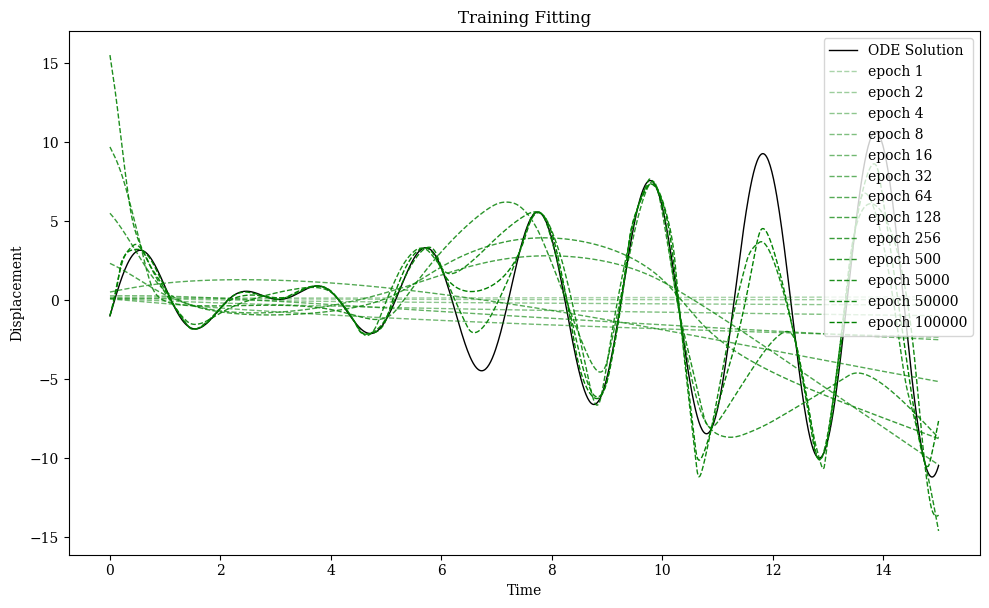

In [139]:
torch.manual_seed(123)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

x_train = torch.tensor(X.query(f"time <= {time_threshold}")["time"].values).float().unsqueeze(1).to(device)
y_train = torch.tensor(X.query(f"time <= {time_threshold}")["displacement"].values).float().unsqueeze(1).to(device)

x_test = torch.tensor(X.query(f"time > {time_threshold}")["time"].values).float().unsqueeze(1).to(device)
y_test = torch.tensor(X.query(f"time > {time_threshold}")["displacement"].values).float().unsqueeze(1).to(device)

hparam_dict = {
    'learning_rate': 5e-4,
    'n_layers': 5,
    'n_neurons': 64,
    'num_epochs': 200000,
 }

learning_rate = hparam_dict["learning_rate"]
num_epochs = hparam_dict["num_epochs"]
architecture = [1] + [hparam_dict["n_neurons"] for _ in range(hparam_dict["n_layers"])] + [1]

plot_loss_train = dict(epoch=[], dataloss=[], physicsloss=[], param_f0=[])

_locations = torch.linspace(0, 15, 50).view(-1,1).requires_grad_(True).to(device)
_m = torch.tensor(m, dtype=torch.float, requires_grad=False).to(device)
_c = torch.tensor(c, dtype=torch.float, requires_grad=False).to(device)
_k = torch.tensor(k, dtype=torch.float, requires_grad=False).to(device)
_w = torch.tensor(w, dtype=torch.float, requires_grad=False).to(device)
_x0 = torch.tensor(x0, dtype=torch.float, requires_grad=False).to(device)
_v0 = torch.tensor(v0, dtype=torch.float, requires_grad=False).to(device)
_phid = torch.tensor(phid, dtype=torch.float, requires_grad=False).to(device)
_F0 = torch.tensor(10, dtype=torch.float, requires_grad=True, device=device)

model = MultiLayerPerceptronRegressor(architecture, nn.ELU)
model.to(device)
optimizer = optim.Adam([{"params": model.parameters()}, {"params": [_F0]}], lr=learning_rate)
criterion = nn.MSELoss()
loss = torch.tensor(1e6, dtype=torch.float, requires_grad=False).to(device)

print(model)

t = np.linspace(0, 15, 1000)
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(10, golden_ratio*10))
ax1.plot(t, driven_oscillator(t, m, k, c, w0, w, F0, x0, v0, phid), label="ODE Solution", c="k", linestyle="-", linewidth=1,)

for epoch in tqdm.tqdm(range(hparam_dict["num_epochs"])):
    if loss.item() > 1e-4 or epoch < 10000:
        optimizer.zero_grad()

        # forward
        y_train_hat = model(x_train)
        data_loss = criterion(y_train_hat, y_train)

        y_location_hat = model(_locations)
        dydt = torch.autograd.grad(y_location_hat, _locations, grad_outputs=torch.ones_like(y_location_hat), create_graph=True)[0]
        dy2dt2 = torch.autograd.grad(dydt, _locations, grad_outputs=torch.ones_like(dydt), create_graph=True)[0]

        _diff_equation = _m*dy2dt2 + _c*dydt + _k*y_location_hat - _F0*torch.cos(_w*_locations-_phid)
        
        if epoch > 7500:
            physics_loss = criterion(_diff_equation, torch.zeros_like(_diff_equation))
            _x0_loss = criterion(y_location_hat[0], _x0)
            _v0_loss = criterion(dydt[0], _v0)
        else:
            physics_loss = torch.tensor(0, dtype=torch.float, requires_grad=False).to(device)
            _x0_loss = torch.tensor(0, dtype=torch.float, requires_grad=False).to(device)
            _v0_loss = torch.tensor(0, dtype=torch.float, requires_grad=False).to(device)

        loss = data_loss + (1e-4)*(physics_loss + _x0_loss + _v0_loss)
        
        # backward
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % 1000 == 0:
            str_epoch = str(epoch+1).zfill(5)
            str_num_epochs = str(num_epochs).zfill(5)
            str_loss = str(round(loss.item(), 4))
            str_physics_loss = str(round(physics_loss.item(), 4))
            # print(f"epoch [{str_epoch}/{str_num_epochs}] loss: {str_loss} physics loss: {str_physics_loss}")
            print("F0: ", _F0.item())
            print(f"Data Loss: {data_loss.item():.6f}, Physics Loss: {physics_loss.item():.6f}, x0 Loss: {_x0_loss.item():.6f}, v0 Loss: {_v0_loss.item():.6f}, Total Loss: {loss.item():.6f}")

        if (epoch+1) % 5 == 0:
            plot_loss_train["epoch"].append(epoch+1)
            plot_loss_train["dataloss"].append(data_loss.item())
            plot_loss_train["physicsloss"].append(physics_loss.item())
            plot_loss_train["param_f0"].append(_F0.item())
        
        _E = [2**0, 2**1, 2**2, 2**3, 2**4, 2**5, 2**6, 2**7, 2**8, 500, 5000, 50000, 100000]
        if (epoch+1) in _E:
            _index = np.where(np.array(_E) == (epoch+1))[0][0]
            model.eval()
            t = np.linspace(0, 15, 1000)
            ax1.plot(
                t, model(torch.tensor(t).float().unsqueeze(1).to(device)).cpu().detach().numpy(), 
                label=f"epoch {epoch+1}", linestyle="--", linewidth=1, c="g", alpha=((_index+1) + 5)/(len(_E) + 5)
            )   

ax1.set_xlabel("Time")
ax1.set_ylabel("Displacement")
ax1.legend()

plt.title("Training Fitting")
plt.tight_layout()

plt.savefig(f"{folder_path}/displacement_vs_time_with_training.png", dpi=300)

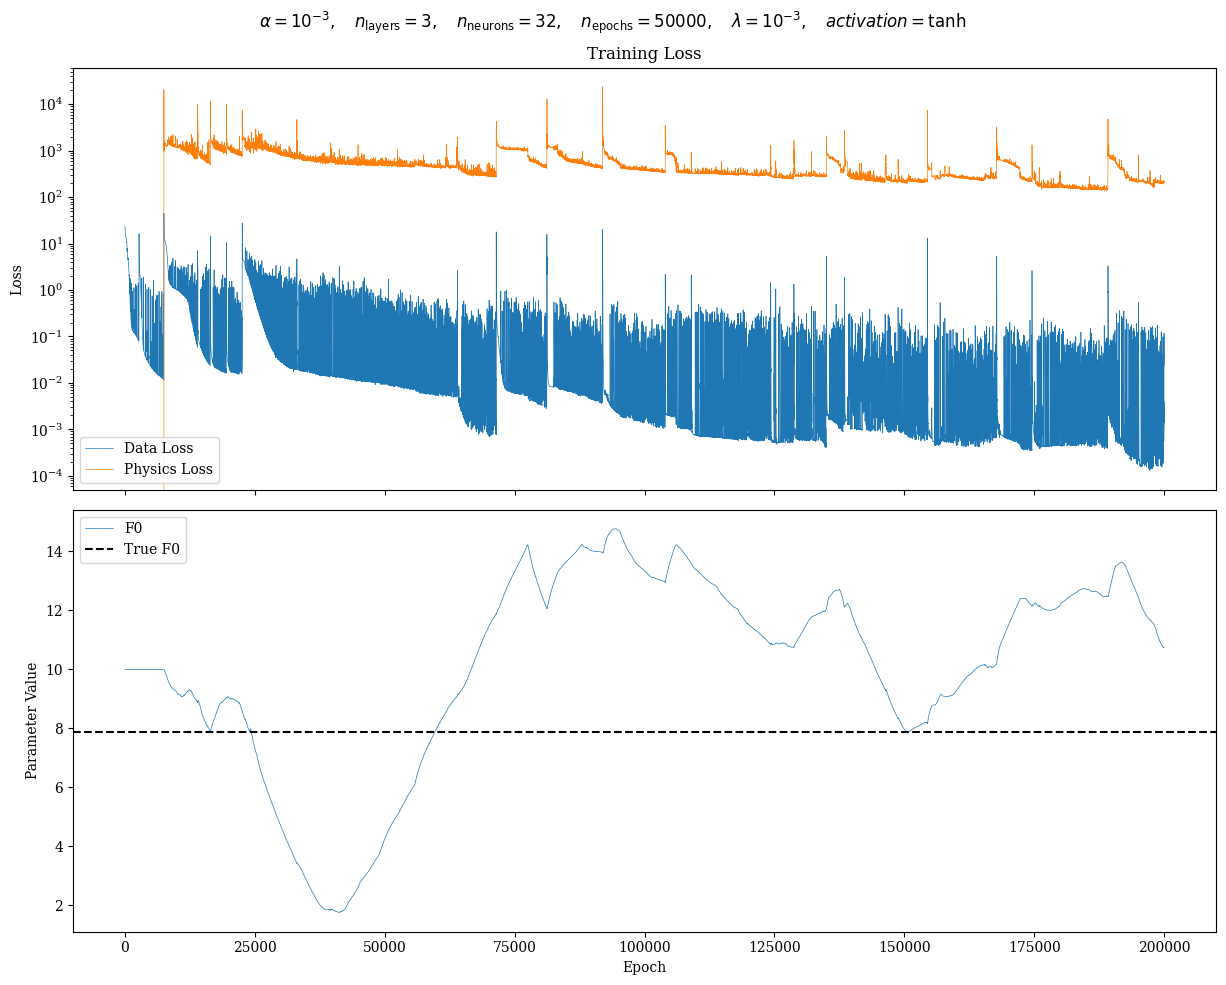

In [143]:
fig, ((ax1, ax2)) = plt.subplots(ncols=1, nrows=2, figsize=(2*golden_ratio*10, 10), sharex=True)

pd.DataFrame(plot_loss_train).plot(x="epoch", y="dataloss",  ax=ax1, label="Data Loss", linewidth=0.5)
pd.DataFrame(plot_loss_train).plot(x="epoch", y="physicsloss", ax=ax1, label="Physics Loss", linewidth=0.5)

ax1.set_xlabel(r"Epoch")
ax1.set_ylabel(r"Loss")
ax1.set_title(r"Training Loss")
ax1.set_yscale('log')
ax1.legend()

pd.DataFrame(plot_loss_train).plot(x="epoch", y="param_f0", ax=ax2, label="F0", linewidth=0.5)
ax2.axhline(y=F0, c="k", linestyle="--", label="True F0")
ax2.set_xlabel(r"Epoch")
ax2.set_ylabel(r"Parameter Value")
ax2.legend()

plt.suptitle(r"$\alpha=10^{-3},\quad n_{\text{layers}}=3,\quad n_{\text{neurons}}=32, \quad n_{\text{epochs}}=50000, \quad \lambda=10^{-3}, \quad activation=\tanh$")
plt.tight_layout()
plt.savefig(f"{folder_path}/training_loss.png", dpi=300)

pd.DataFrame(x_train.cpu().numpy(), columns=["time"]).to_parquet(f"{folder_path}/x_train.parquet")
pd.DataFrame(y_train.cpu().numpy(), columns=["displacement"]).to_parquet(f"{folder_path}/y_train.parquet")

torch.save(model, f"{folder_path}/pinn_model.pth")
torch.save(model.state_dict(), f"{folder_path}/pinn_weights.pth")

# results

10.0 1 9


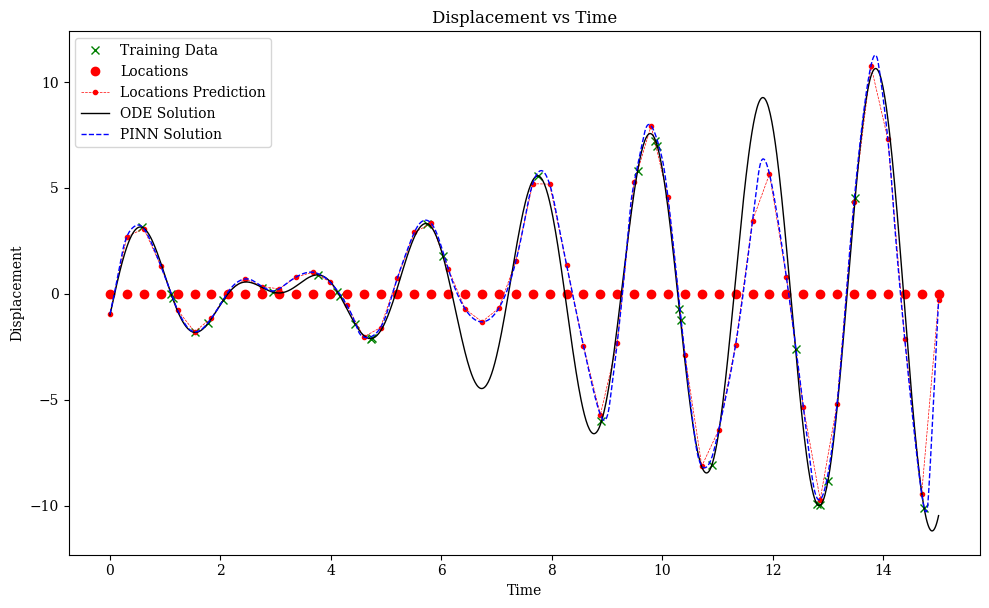

In [144]:
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(10, golden_ratio*10))

model.eval()

with torch.no_grad():
    X["y_hat"] = model(torch.tensor(X["time"].values).float().unsqueeze(1).to(device)).cpu().detach().numpy()

X.query(f"time <= {time_threshold}").plot(
    x="time", y="displacement", 
    marker="x", c="g", linestyle="none", linewidth=0.5,
    ax=ax1, label="Training Data"
)

# X.query(f"time > {time_threshold}").plot(
#     x="time", y="displacement", 
#     marker="x", c="r", linestyle="none", linewidth=0.5,
#     ax=ax1, label="Test Data"
# )

ax1.plot(
    _locations.cpu().detach().numpy().reshape(-1, 1),
    model(_locations).cpu().detach().numpy().reshape(-1)*0, 
    c="r", linestyle="none", marker="o", linewidth=0.5,
    label=r"Locations", 
)

ax1.plot(
    _locations.cpu().detach().numpy().reshape(-1, 1),
    model(_locations).cpu().detach().numpy().reshape(-1), 
    c="r", linestyle="--", marker=".", linewidth=0.5,
    label=r"Locations Prediction"
) 

t = np.linspace(0, 15, 1000)
ax1.plot(t, driven_oscillator(t, m, k, c, w0, w, F0, x0, v0, phid), label="ODE Solution", c="k", linestyle="-", linewidth=1,)
ax1.plot(t, model(torch.tensor(t).float().unsqueeze(1).to(device)).cpu().detach().numpy(), label="PINN Solution", c="b", linestyle="--", linewidth=1,)

ax1.set_xlabel("Time")
ax1.set_ylabel("Displacement")
ax1.legend()

plt.title("Displacement vs Time")
plt.tight_layout()

plt.savefig(f"{folder_path}/displacement_vs_time_with_predictions.png", dpi=300)

10.0 1 9
10.0 1 9


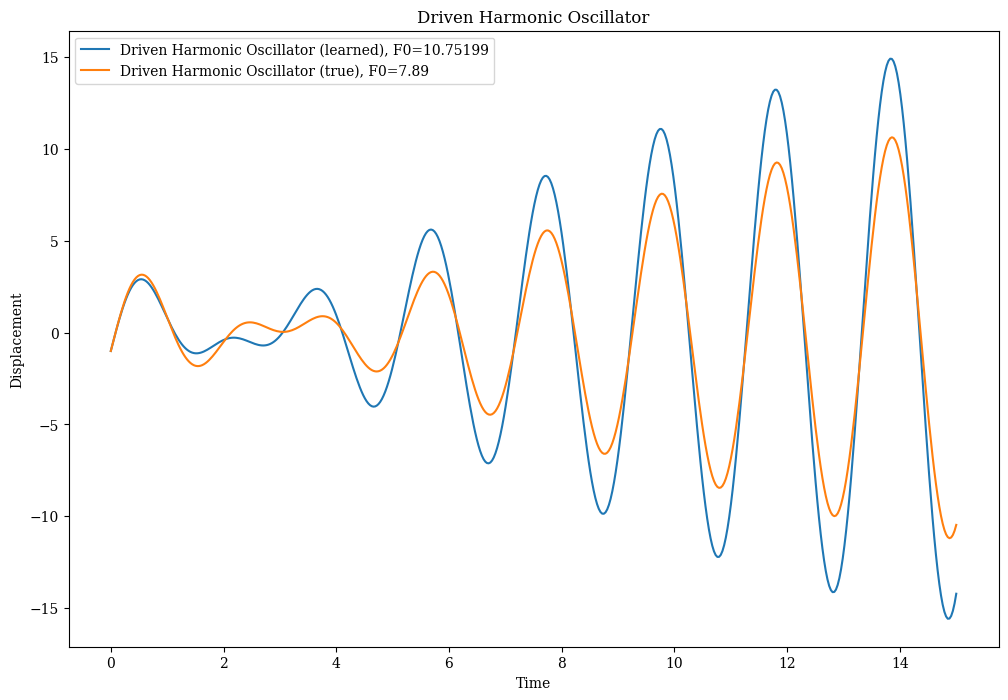

In [145]:
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(10, golden_ratio*10))

x = torch.linspace(0,15,500).view(-1,1)
y = driven_oscillator(x, m, k, c, w0, w, _F0.item(), x0, v0, phid)
df = pd.DataFrame({"time": x.squeeze(), "displacement": y.squeeze()})
df.plot(x="time", y="displacement", figsize=(12, 8), label=f"Driven Harmonic Oscillator (learned), F0={round(_F0.item(), 5)}", ax=ax1)

x = torch.linspace(0,15,500).view(-1,1)
y = driven_oscillator(x, m, k, c, w0, w, F0, x0, v0, phid)
df = pd.DataFrame({"time": x.squeeze(), "displacement": y.squeeze()})
df.plot(x="time", y="displacement", figsize=(12, 8), label=f"Driven Harmonic Oscillator (true), F0={round(F0, 5)}", ax=ax1)

ax1.set_xlabel("Time")
ax1.set_ylabel("Displacement")
ax1.set_title("Driven Harmonic Oscillator")

ax1.legend()

# other parameters

In [13]:
experiment_name = "dho_parameter_learning/mass"

folder_path = f"../data/08_reporting/{experiment_name}"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)


10.0 0.789 9


,time,displacement
0,4.441679,-3.864460
1,7.748434,1.690193
2,3.775061,2.613969
3,10.328352,-3.695580
4,1.109587,-0.896937


10.0 0.789 9


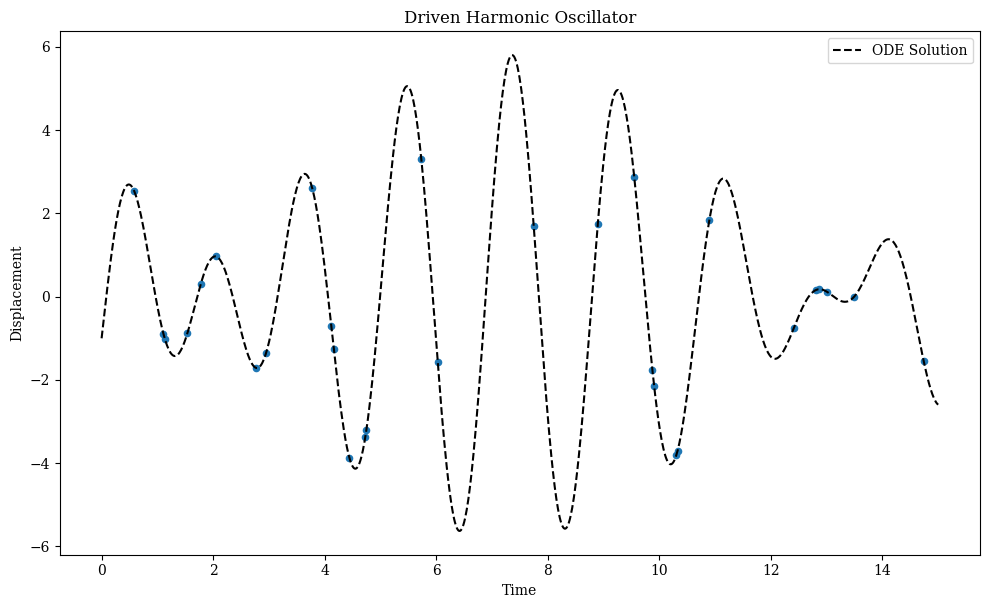

In [14]:

def driven_oscillator(t, m, k, c, w0, w, F0, x0, v0, phid):
    """
    driven_oscillator
    """
    w0 = np.sqrt(k/m)
    gamma = c/2/m
    
    wprime = np.sqrt(w0**2 - gamma**2)
    A = F0 / m / np.sqrt((w0**2 - w**2)**2 + 4 * gamma**2 * w**2 )
    
    print(k, m, w**2)
    phi = np.arctan(c * w / (k - m * w**2)) - phid
    phih = np.arctan(wprime * (x0 - A * np.cos(phi)) \
        / (v0 + gamma * (x0 - A * np.cos(phi)) - A * w * np.sin(phi) ) )
    
    Ah = (x0 - A * np.cos(phi)) / np.sin(phih)
    
    x = Ah * np.exp(-gamma * t) * np.sin(wprime * t + phih) + A * np.cos(w * t - phi)
    
    return x

torch.manual_seed(123)

d, w0 = 0.5, 20
m = 0.789
k = 1e1
c = 0.05
w = 3
F0 = 7.89
x0 = -1
v0 = 12
phid = np.pi

x = torch.rand(30)*15
y = driven_oscillator(x, m, k, c, w0, w, F0, x0, v0, phid)

X = pd.DataFrame({"time": x.squeeze(), "displacement": y.squeeze()})
X.to_parquet(f"{folder_path}/synthetic_data.parquet")

display(X.head())

fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(10, golden_ratio*10))

t = np.linspace(0, 15, 1000)
X.plot.scatter(x="time", y="displacement", ax=ax1)
ax1.plot(t, driven_oscillator(t, m, k, c, w0, w, F0, x0, v0, phid), label="ODE Solution", c="k", linestyle="--",)

ax1.set_xlabel("Time")
ax1.set_ylabel("Displacement")
ax1.set_title("Driven Harmonic Oscillator")
ax1.legend()

plt.tight_layout()
plt.savefig(f"{folder_path}/displacement_vs_time.png", dpi=300)

MultiLayerPerceptronRegressor(
  (architecture): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)
10.0 0.789 9


  0%|          | 0/150000 [00:00<?, ?it/s]

  1%|          | 1029/150000 [00:03<08:42, 285.35it/s]

m:  3.2100000381469727
Data Loss: 0.115068, Physics Loss: 0.000000, x0 Loss: 0.000000, v0 Loss: 0.000000, Total Loss: 0.115068


  1%|▏         | 2040/150000 [00:06<09:25, 261.67it/s]

m:  3.2100000381469727
Data Loss: 0.059113, Physics Loss: 0.000000, x0 Loss: 0.000000, v0 Loss: 0.000000, Total Loss: 0.059113


  2%|▏         | 3040/150000 [00:09<08:14, 296.99it/s]

m:  3.2100000381469727
Data Loss: 0.028987, Physics Loss: 0.000000, x0 Loss: 0.000000, v0 Loss: 0.000000, Total Loss: 0.028987


  3%|▎         | 4058/150000 [00:13<07:26, 326.59it/s]

m:  3.2100000381469727
Data Loss: 0.002190, Physics Loss: 0.000000, x0 Loss: 0.000000, v0 Loss: 0.000000, Total Loss: 0.002190


  3%|▎         | 5059/150000 [00:15<06:28, 373.33it/s]

m:  3.2100000381469727
Data Loss: 0.000759, Physics Loss: 0.000000, x0 Loss: 0.000000, v0 Loss: 0.000000, Total Loss: 0.000759


  4%|▍         | 6034/150000 [00:18<06:44, 356.08it/s]

m:  3.2100000381469727
Data Loss: 0.000596, Physics Loss: 0.000000, x0 Loss: 0.000000, v0 Loss: 0.000000, Total Loss: 0.000596


  5%|▍         | 7039/150000 [00:20<07:03, 337.19it/s]

m:  3.2100000381469727
Data Loss: 0.016144, Physics Loss: 0.000000, x0 Loss: 0.000000, v0 Loss: 0.000000, Total Loss: 0.016144


  5%|▌         | 8027/150000 [00:25<11:15, 210.19it/s]

m:  2.987534284591675
Data Loss: 0.070040, Physics Loss: 1042.581787, x0 Loss: 9.403868, v0 Loss: 64.113396, Total Loss: 0.181650


  6%|▌         | 9024/150000 [00:30<11:56, 196.68it/s]

m:  2.282400369644165
Data Loss: 0.278268, Physics Loss: 1007.330994, x0 Loss: 2.508437, v0 Loss: 24.387911, Total Loss: 0.381690


  7%|▋         | 10030/150000 [00:35<11:45, 198.48it/s]

m:  1.5459555387496948
Data Loss: 0.112614, Physics Loss: 382.545807, x0 Loss: 0.325777, v0 Loss: 3.801023, Total Loss: 0.151281


  7%|▋         | 11045/150000 [00:39<10:00, 231.59it/s]

m:  1.0164393186569214
Data Loss: 0.007702, Physics Loss: 186.778732, x0 Loss: 0.005079, v0 Loss: 0.604676, Total Loss: 0.026441


  8%|▊         | 12026/150000 [00:44<11:17, 203.62it/s]

m:  0.5892763733863831
Data Loss: 0.003146, Physics Loss: 106.992821, x0 Loss: 0.064402, v0 Loss: 0.032228, Total Loss: 0.013855


  9%|▊         | 13027/150000 [00:49<10:39, 214.22it/s]

m:  0.3747238516807556
Data Loss: 0.001251, Physics Loss: 104.931198, x0 Loss: 0.313055, v0 Loss: 0.372444, Total Loss: 0.011812


  9%|▉         | 14037/150000 [00:53<10:14, 221.29it/s]

m:  0.2903698980808258
Data Loss: 0.014411, Physics Loss: 132.860352, x0 Loss: 0.006390, v0 Loss: 0.036566, Total Loss: 0.027702


 10%|█         | 15024/150000 [00:58<10:56, 205.60it/s]

m:  0.2537647485733032
Data Loss: 0.001519, Physics Loss: 142.602676, x0 Loss: 0.023113, v0 Loss: 0.017039, Total Loss: 0.015783


 11%|█         | 16044/150000 [01:03<10:00, 223.17it/s]

m:  0.2172960340976715
Data Loss: 0.006189, Physics Loss: 138.362183, x0 Loss: 0.011366, v0 Loss: 0.038341, Total Loss: 0.020030


 11%|█▏        | 17029/150000 [01:08<15:08, 146.30it/s]

m:  0.2190280705690384
Data Loss: 0.006754, Physics Loss: 131.664993, x0 Loss: 0.017065, v0 Loss: 0.055761, Total Loss: 0.019928


 12%|█▏        | 18039/150000 [01:13<09:16, 237.26it/s]

m:  0.22649133205413818
Data Loss: 0.001148, Physics Loss: 129.113266, x0 Loss: 0.062678, v0 Loss: 0.040955, Total Loss: 0.014070


 13%|█▎        | 19038/150000 [01:18<09:55, 219.76it/s]

m:  0.2351611703634262
Data Loss: 0.001614, Physics Loss: 126.954819, x0 Loss: 0.071568, v0 Loss: 0.051299, Total Loss: 0.014322


 13%|█▎        | 20030/150000 [01:24<14:14, 152.18it/s]

m:  0.2315683215856552
Data Loss: 0.009181, Physics Loss: 129.524826, x0 Loss: 0.044943, v0 Loss: 0.110160, Total Loss: 0.022149


 14%|█▍        | 21031/150000 [01:29<09:22, 229.46it/s]

m:  0.24383406341075897
Data Loss: 0.012659, Physics Loss: 125.216530, x0 Loss: 1.051813, v0 Loss: 0.032784, Total Loss: 0.025289


 15%|█▍        | 22031/150000 [01:34<09:16, 230.14it/s]

m:  0.2478397935628891
Data Loss: 0.003368, Physics Loss: 121.862740, x0 Loss: 0.939765, v0 Loss: 0.066117, Total Loss: 0.015655


 15%|█▌        | 23025/150000 [01:38<10:10, 208.09it/s]

m:  0.25536638498306274
Data Loss: 0.001123, Physics Loss: 122.228905, x0 Loss: 0.616912, v0 Loss: 0.011944, Total Loss: 0.013409


 16%|█▌        | 24029/150000 [01:44<09:15, 226.80it/s]

m:  0.25842681527137756
Data Loss: 0.003141, Physics Loss: 121.610123, x0 Loss: 0.486859, v0 Loss: 0.102730, Total Loss: 0.015361


 17%|█▋        | 25028/150000 [01:49<11:01, 189.05it/s]

m:  0.2561838924884796
Data Loss: 0.002982, Physics Loss: 120.749702, x0 Loss: 0.419827, v0 Loss: 0.020865, Total Loss: 0.015101


 17%|█▋        | 26024/150000 [01:54<11:47, 175.35it/s]

m:  0.2575974464416504
Data Loss: 0.000959, Physics Loss: 119.213623, x0 Loss: 0.141790, v0 Loss: 0.048386, Total Loss: 0.012900


 18%|█▊        | 27026/150000 [02:00<10:51, 188.85it/s]

m:  0.2477574646472931
Data Loss: 0.017486, Physics Loss: 123.890038, x0 Loss: 0.024086, v0 Loss: 0.848052, Total Loss: 0.029962


 19%|█▊        | 28038/150000 [02:06<10:41, 190.01it/s]

m:  0.30325230956077576
Data Loss: 0.025592, Physics Loss: 134.836838, x0 Loss: 0.127451, v0 Loss: 1.196416, Total Loss: 0.039208


 19%|█▉        | 29034/150000 [02:11<10:52, 185.49it/s]

m:  0.2900790274143219
Data Loss: 0.007970, Physics Loss: 138.360992, x0 Loss: 0.320512, v0 Loss: 0.045693, Total Loss: 0.021843


 20%|██        | 30025/150000 [02:16<10:40, 187.37it/s]

m:  0.3001294732093811
Data Loss: 0.002157, Physics Loss: 138.620392, x0 Loss: 0.072005, v0 Loss: 0.002092, Total Loss: 0.016026


 21%|██        | 31022/150000 [02:22<10:53, 181.92it/s]

m:  0.30708107352256775
Data Loss: 0.006507, Physics Loss: 136.748840, x0 Loss: 0.009968, v0 Loss: 1.688669, Total Loss: 0.020352


 21%|██▏       | 32045/150000 [02:26<08:02, 244.56it/s]

m:  0.3188849091529846
Data Loss: 0.000705, Physics Loss: 137.385468, x0 Loss: 0.004240, v0 Loss: 0.817617, Total Loss: 0.014526


 22%|██▏       | 33026/150000 [02:30<07:50, 248.50it/s]

m:  0.30394068360328674
Data Loss: 0.000624, Physics Loss: 131.034027, x0 Loss: 0.042357, v0 Loss: 0.001006, Total Loss: 0.013731


 23%|██▎       | 34034/150000 [02:35<08:32, 226.39it/s]

m:  0.23109030723571777
Data Loss: 0.001127, Physics Loss: 133.345245, x0 Loss: 0.011107, v0 Loss: 0.693017, Total Loss: 0.014532


 23%|██▎       | 35042/150000 [02:39<08:48, 217.31it/s]

m:  0.25018513202667236
Data Loss: 0.001085, Physics Loss: 129.197708, x0 Loss: 0.148678, v0 Loss: 0.037165, Total Loss: 0.014024


 24%|██▍       | 36021/150000 [02:44<09:46, 194.26it/s]

m:  0.30095919966697693
Data Loss: 0.000594, Physics Loss: 130.629639, x0 Loss: 0.017847, v0 Loss: 0.003157, Total Loss: 0.013659


 25%|██▍       | 37026/150000 [02:50<09:53, 190.26it/s]

m:  0.3075432777404785
Data Loss: 0.000620, Physics Loss: 130.028610, x0 Loss: 0.010996, v0 Loss: 0.000362, Total Loss: 0.013624


 25%|██▌       | 38019/150000 [02:55<08:45, 213.01it/s]

m:  0.3040665090084076
Data Loss: 0.000620, Physics Loss: 132.773148, x0 Loss: 0.053367, v0 Loss: 0.007845, Total Loss: 0.013903


 26%|██▌       | 39039/150000 [03:00<09:03, 204.04it/s]

m:  0.30810463428497314
Data Loss: 0.002897, Physics Loss: 126.920097, x0 Loss: 0.079202, v0 Loss: 0.168067, Total Loss: 0.015614


 27%|██▋       | 40022/150000 [03:05<09:15, 197.93it/s]

m:  0.3108822703361511
Data Loss: 0.000598, Physics Loss: 122.349823, x0 Loss: 0.232766, v0 Loss: 0.094340, Total Loss: 0.012866


 27%|██▋       | 41038/150000 [03:10<07:57, 228.30it/s]

m:  0.31725531816482544
Data Loss: 0.000664, Physics Loss: 124.054695, x0 Loss: 0.020496, v0 Loss: 0.000379, Total Loss: 0.013071


 28%|██▊       | 42032/150000 [03:14<07:57, 226.26it/s]

m:  0.32415279746055603
Data Loss: 0.000630, Physics Loss: 122.586716, x0 Loss: 1.113074, v0 Loss: 0.003069, Total Loss: 0.013000


 29%|██▊       | 43036/150000 [03:19<07:45, 229.89it/s]

m:  0.3199262022972107
Data Loss: 0.000709, Physics Loss: 122.265739, x0 Loss: 0.137650, v0 Loss: 0.014539, Total Loss: 0.012951


 29%|██▉       | 44028/150000 [03:23<07:58, 221.35it/s]

m:  0.3284144401550293
Data Loss: 0.000578, Physics Loss: 123.418045, x0 Loss: 0.067042, v0 Loss: 0.005405, Total Loss: 0.012927


 30%|███       | 45030/150000 [03:28<08:49, 198.07it/s]

m:  0.3284471333026886
Data Loss: 0.004935, Physics Loss: 123.101677, x0 Loss: 0.042325, v0 Loss: 0.018478, Total Loss: 0.017252


 31%|███       | 46028/150000 [03:32<08:14, 210.27it/s]

m:  0.3325498700141907
Data Loss: 0.013292, Physics Loss: 124.101578, x0 Loss: 0.004560, v0 Loss: 0.011892, Total Loss: 0.025703


 31%|███▏      | 47039/150000 [03:37<08:39, 198.05it/s]

m:  0.3349924683570862
Data Loss: 0.000609, Physics Loss: 118.171547, x0 Loss: 0.000207, v0 Loss: 0.000001, Total Loss: 0.012426


 32%|███▏      | 48026/150000 [03:43<08:29, 200.15it/s]

m:  0.3317452669143677
Data Loss: 0.000602, Physics Loss: 123.612282, x0 Loss: 0.014732, v0 Loss: 0.015560, Total Loss: 0.012966


 33%|███▎      | 49042/150000 [03:47<07:20, 229.27it/s]

m:  0.3483697772026062
Data Loss: 0.002133, Physics Loss: 115.646492, x0 Loss: 0.001872, v0 Loss: 0.000126, Total Loss: 0.013697


 33%|███▎      | 50038/150000 [03:52<07:08, 233.20it/s]

m:  0.34741589426994324
Data Loss: 0.013763, Physics Loss: 118.949356, x0 Loss: 0.001639, v0 Loss: 0.011170, Total Loss: 0.025660


 34%|███▍      | 51032/150000 [03:57<10:24, 158.43it/s]

m:  0.3369108736515045
Data Loss: 0.001681, Physics Loss: 116.125076, x0 Loss: 0.000086, v0 Loss: 0.000405, Total Loss: 0.013294


 35%|███▍      | 52015/150000 [04:04<10:17, 158.73it/s]

m:  0.3488810062408447
Data Loss: 0.004265, Physics Loss: 115.787468, x0 Loss: 0.002361, v0 Loss: 0.002684, Total Loss: 0.015844


 35%|███▌      | 53020/150000 [04:10<08:33, 188.72it/s]

m:  0.36118048429489136
Data Loss: 0.005655, Physics Loss: 116.744965, x0 Loss: 0.012075, v0 Loss: 0.001452, Total Loss: 0.017331


 36%|███▌      | 54021/150000 [04:16<11:35, 137.91it/s]

m:  0.37724706530570984
Data Loss: 0.000671, Physics Loss: 113.249451, x0 Loss: 0.000528, v0 Loss: 0.000034, Total Loss: 0.011996


 37%|███▋      | 55031/150000 [04:23<09:23, 168.51it/s]

m:  0.38277187943458557
Data Loss: 0.001145, Physics Loss: 106.651978, x0 Loss: 0.000024, v0 Loss: 0.046723, Total Loss: 0.011815


 37%|███▋      | 56030/150000 [04:29<08:42, 179.89it/s]

m:  0.3829416334629059
Data Loss: 0.001053, Physics Loss: 108.226562, x0 Loss: 0.002031, v0 Loss: 0.000349, Total Loss: 0.011876


 38%|███▊      | 57025/150000 [04:35<09:17, 166.71it/s]

m:  0.38867297768592834
Data Loss: 0.000971, Physics Loss: 106.827957, x0 Loss: 0.008073, v0 Loss: 0.000710, Total Loss: 0.011655


 39%|███▊      | 58016/150000 [04:41<09:43, 157.54it/s]

m:  0.40168777108192444
Data Loss: 0.007702, Physics Loss: 103.783875, x0 Loss: 0.013365, v0 Loss: 0.022125, Total Loss: 0.018084


 39%|███▉      | 59036/150000 [04:47<07:43, 196.44it/s]

m:  0.3948186933994293
Data Loss: 0.001269, Physics Loss: 115.427666, x0 Loss: 0.007504, v0 Loss: 0.026546, Total Loss: 0.012815


 40%|████      | 60025/150000 [04:51<06:04, 246.95it/s]

m:  0.3997749388217926
Data Loss: 0.001827, Physics Loss: 107.942345, x0 Loss: 0.000637, v0 Loss: 0.014637, Total Loss: 0.012622


 41%|████      | 61019/150000 [04:55<06:57, 213.29it/s]

m:  0.4045684337615967
Data Loss: 0.011057, Physics Loss: 103.590790, x0 Loss: 0.000659, v0 Loss: 0.060313, Total Loss: 0.021423


 41%|████▏     | 62035/150000 [05:00<07:28, 196.16it/s]

m:  0.39209699630737305
Data Loss: 0.001961, Physics Loss: 100.810875, x0 Loss: 0.000036, v0 Loss: 0.000050, Total Loss: 0.012042


 42%|████▏     | 63040/150000 [05:05<07:08, 202.79it/s]

m:  0.4161655604839325
Data Loss: 0.000658, Physics Loss: 96.734322, x0 Loss: 0.025202, v0 Loss: 0.000011, Total Loss: 0.010334


 43%|████▎     | 64036/150000 [05:09<06:18, 227.25it/s]

m:  0.4104718565940857
Data Loss: 0.003519, Physics Loss: 95.442070, x0 Loss: 0.005378, v0 Loss: 0.003184, Total Loss: 0.013064


 43%|████▎     | 65029/150000 [05:14<06:18, 224.47it/s]

m:  0.38621917366981506
Data Loss: 0.010523, Physics Loss: 101.076363, x0 Loss: 0.002301, v0 Loss: 0.001666, Total Loss: 0.020631


 44%|████▍     | 66024/150000 [05:19<06:06, 229.13it/s]

m:  0.41739046573638916
Data Loss: 0.002160, Physics Loss: 99.401733, x0 Loss: 0.025971, v0 Loss: 0.025807, Total Loss: 0.012105


 45%|████▍     | 67027/150000 [05:23<05:49, 237.58it/s]

m:  0.3807758688926697
Data Loss: 0.000513, Physics Loss: 95.977264, x0 Loss: 0.004143, v0 Loss: 0.000016, Total Loss: 0.010111


 45%|████▌     | 68036/150000 [05:28<05:55, 230.30it/s]

m:  0.34578025341033936
Data Loss: 0.000883, Physics Loss: 90.309334, x0 Loss: 0.000000, v0 Loss: 0.000217, Total Loss: 0.009914


 46%|████▌     | 69028/150000 [05:33<07:58, 169.23it/s]

m:  0.34324875473976135
Data Loss: 0.001249, Physics Loss: 97.217148, x0 Loss: 0.002219, v0 Loss: 0.000613, Total Loss: 0.010971


 47%|████▋     | 70024/150000 [05:38<07:11, 185.22it/s]

m:  0.3337482511997223
Data Loss: 0.000532, Physics Loss: 95.228867, x0 Loss: 0.001418, v0 Loss: 0.001299, Total Loss: 0.010055


 47%|████▋     | 71026/150000 [05:44<07:05, 185.51it/s]

m:  0.33466845750808716
Data Loss: 0.001817, Physics Loss: 89.676559, x0 Loss: 0.003167, v0 Loss: 0.003831, Total Loss: 0.010785


 48%|████▊     | 72033/150000 [05:50<06:52, 188.79it/s]

m:  0.3372640311717987
Data Loss: 0.000501, Physics Loss: 89.656349, x0 Loss: 0.000798, v0 Loss: 0.001848, Total Loss: 0.009467


 49%|████▊     | 73019/150000 [05:56<09:40, 132.66it/s]

m:  0.33080413937568665
Data Loss: 0.002864, Physics Loss: 88.932869, x0 Loss: 0.002254, v0 Loss: 0.012028, Total Loss: 0.011759


 49%|████▉     | 74032/150000 [06:02<07:51, 161.22it/s]

m:  0.34049129486083984
Data Loss: 0.001261, Physics Loss: 97.473885, x0 Loss: 0.000125, v0 Loss: 0.001331, Total Loss: 0.011008


 50%|█████     | 75021/150000 [06:08<08:48, 141.92it/s]

m:  0.34259626269340515
Data Loss: 0.020826, Physics Loss: 102.774147, x0 Loss: 0.000685, v0 Loss: 0.019846, Total Loss: 0.031105


 51%|█████     | 76027/150000 [06:15<08:21, 147.54it/s]

m:  0.3405397832393646
Data Loss: 0.002742, Physics Loss: 89.497856, x0 Loss: 0.001331, v0 Loss: 0.001874, Total Loss: 0.011692


 51%|█████▏    | 77040/150000 [06:21<06:01, 201.59it/s]

m:  0.3320050537586212
Data Loss: 0.000928, Physics Loss: 89.275116, x0 Loss: 0.000698, v0 Loss: 0.001732, Total Loss: 0.009856


 52%|█████▏    | 78023/150000 [06:26<06:09, 194.95it/s]

m:  0.3379078209400177
Data Loss: 0.001329, Physics Loss: 91.871910, x0 Loss: 0.043186, v0 Loss: 0.010169, Total Loss: 0.010521


 53%|█████▎    | 79029/150000 [06:31<05:46, 204.85it/s]

m:  0.3421061038970947
Data Loss: 0.005420, Physics Loss: 89.677628, x0 Loss: 0.008970, v0 Loss: 0.003280, Total Loss: 0.014389


 53%|█████▎    | 80026/150000 [06:36<06:03, 192.48it/s]

m:  0.33898258209228516
Data Loss: 0.022961, Physics Loss: 94.866150, x0 Loss: 0.016724, v0 Loss: 0.030880, Total Loss: 0.032453


 54%|█████▍    | 81039/150000 [06:41<05:21, 214.59it/s]

m:  0.3446110188961029
Data Loss: 0.001322, Physics Loss: 96.956375, x0 Loss: 0.005103, v0 Loss: 0.010021, Total Loss: 0.011019


 55%|█████▍    | 82031/150000 [06:45<05:07, 221.03it/s]

m:  0.3390843868255615
Data Loss: 0.003289, Physics Loss: 94.229469, x0 Loss: 0.000621, v0 Loss: 0.000580, Total Loss: 0.012712


 55%|█████▌    | 83030/150000 [06:50<04:54, 227.44it/s]

m:  0.35162779688835144
Data Loss: 0.003335, Physics Loss: 93.458054, x0 Loss: 0.004538, v0 Loss: 0.001154, Total Loss: 0.012681


 56%|█████▌    | 84041/150000 [06:55<05:07, 214.38it/s]

m:  0.35203269124031067
Data Loss: 0.000534, Physics Loss: 86.761642, x0 Loss: 0.000676, v0 Loss: 0.002671, Total Loss: 0.009210


 57%|█████▋    | 85041/150000 [06:59<04:47, 225.79it/s]

m:  0.34604790806770325
Data Loss: 0.000236, Physics Loss: 88.369568, x0 Loss: 0.000005, v0 Loss: 0.027093, Total Loss: 0.009075


 57%|█████▋    | 86034/150000 [07:04<05:38, 189.20it/s]

m:  0.34625890851020813
Data Loss: 0.004239, Physics Loss: 89.941589, x0 Loss: 0.017385, v0 Loss: 0.000023, Total Loss: 0.013235


 58%|█████▊    | 87025/150000 [07:09<04:46, 220.14it/s]

m:  0.35250264406204224
Data Loss: 0.005966, Physics Loss: 87.367775, x0 Loss: 0.006862, v0 Loss: 0.000039, Total Loss: 0.014704


 59%|█████▊    | 88029/150000 [07:14<05:16, 195.59it/s]

m:  0.35323911905288696
Data Loss: 0.000780, Physics Loss: 95.042915, x0 Loss: 0.005679, v0 Loss: 0.000410, Total Loss: 0.010285


 59%|█████▉    | 89037/150000 [07:19<05:14, 194.07it/s]

m:  0.355950266122818
Data Loss: 0.001602, Physics Loss: 92.362091, x0 Loss: 0.000002, v0 Loss: 0.035343, Total Loss: 0.010842


 60%|██████    | 90034/150000 [07:24<05:07, 195.19it/s]

m:  0.3614453673362732
Data Loss: 0.000510, Physics Loss: 91.925034, x0 Loss: 0.000256, v0 Loss: 0.000061, Total Loss: 0.009702


 61%|██████    | 91034/150000 [07:29<05:07, 191.52it/s]

m:  0.36455807089805603
Data Loss: 0.001033, Physics Loss: 93.631554, x0 Loss: 0.001891, v0 Loss: 0.001070, Total Loss: 0.010396


 61%|██████▏   | 92024/150000 [07:34<05:05, 189.78it/s]

m:  0.3478468060493469
Data Loss: 0.003529, Physics Loss: 94.229919, x0 Loss: 0.001960, v0 Loss: 0.008704, Total Loss: 0.012953


 62%|██████▏   | 93034/150000 [07:39<04:27, 213.07it/s]

m:  0.4375499486923218
Data Loss: 0.000356, Physics Loss: 90.800758, x0 Loss: 0.000048, v0 Loss: 0.000187, Total Loss: 0.009436


 63%|██████▎   | 94023/150000 [07:44<04:49, 193.53it/s]

m:  0.4351745843887329
Data Loss: 0.001989, Physics Loss: 90.801369, x0 Loss: 0.016131, v0 Loss: 0.050975, Total Loss: 0.011076


 63%|██████▎   | 95033/150000 [07:49<04:18, 212.90it/s]

m:  0.4389801025390625
Data Loss: 0.002648, Physics Loss: 86.436676, x0 Loss: 0.000074, v0 Loss: 0.001748, Total Loss: 0.011292


 64%|██████▍   | 96041/150000 [07:53<03:49, 235.21it/s]

m:  0.4390368163585663
Data Loss: 0.001031, Physics Loss: 85.684120, x0 Loss: 0.000715, v0 Loss: 0.001932, Total Loss: 0.009599


 65%|██████▍   | 97030/150000 [07:58<03:56, 224.41it/s]

m:  0.4381140470504761
Data Loss: 0.000639, Physics Loss: 84.210526, x0 Loss: 0.000029, v0 Loss: 0.000145, Total Loss: 0.009060


 65%|██████▌   | 98037/150000 [08:02<03:47, 227.98it/s]

m:  0.44338124990463257
Data Loss: 0.000295, Physics Loss: 84.293770, x0 Loss: 0.018253, v0 Loss: 0.001423, Total Loss: 0.008726


 66%|██████▌   | 99035/150000 [08:07<04:09, 204.19it/s]

m:  0.4408320486545563
Data Loss: 0.000715, Physics Loss: 82.408478, x0 Loss: 0.000355, v0 Loss: 0.000052, Total Loss: 0.008956


 67%|██████▋   | 100038/150000 [08:11<03:25, 242.59it/s]

m:  0.4450835585594177
Data Loss: 0.000285, Physics Loss: 81.887917, x0 Loss: 0.000002, v0 Loss: 0.000000, Total Loss: 0.008474


 67%|██████▋   | 101037/150000 [08:15<03:53, 210.10it/s]

m:  0.44067221879959106
Data Loss: 0.000289, Physics Loss: 83.064644, x0 Loss: 0.000000, v0 Loss: 0.000004, Total Loss: 0.008596


 68%|██████▊   | 102037/150000 [08:20<04:01, 198.70it/s]

m:  0.428636759519577
Data Loss: 0.000320, Physics Loss: 86.614151, x0 Loss: 0.000017, v0 Loss: 0.000020, Total Loss: 0.008981


 69%|██████▊   | 103033/150000 [08:24<03:28, 224.76it/s]

m:  0.45155930519104004
Data Loss: 0.002399, Physics Loss: 82.148338, x0 Loss: 0.000727, v0 Loss: 0.000082, Total Loss: 0.010614


 69%|██████▉   | 104023/150000 [08:29<03:21, 228.31it/s]

m:  0.40783607959747314
Data Loss: 0.000252, Physics Loss: 108.784370, x0 Loss: 0.000162, v0 Loss: 0.000045, Total Loss: 0.011131


 70%|███████   | 105025/150000 [08:33<03:35, 208.56it/s]

m:  0.3506617248058319
Data Loss: 0.000314, Physics Loss: 99.724625, x0 Loss: 0.000005, v0 Loss: 0.000173, Total Loss: 0.010286


 71%|███████   | 106038/150000 [08:38<03:12, 227.84it/s]

m:  0.30815914273262024
Data Loss: 0.000489, Physics Loss: 98.896172, x0 Loss: 0.000019, v0 Loss: 0.000131, Total Loss: 0.010379


 71%|███████▏  | 107045/150000 [08:42<02:50, 251.78it/s]

m:  0.29450467228889465
Data Loss: 0.012560, Physics Loss: 98.543159, x0 Loss: 0.001828, v0 Loss: 0.004219, Total Loss: 0.022415


 72%|███████▏  | 108035/150000 [08:46<02:57, 235.91it/s]

m:  0.3176586627960205
Data Loss: 0.000343, Physics Loss: 94.153687, x0 Loss: 0.002704, v0 Loss: 0.000485, Total Loss: 0.009759


 73%|███████▎  | 109037/150000 [08:51<03:07, 218.65it/s]

m:  0.3213541805744171
Data Loss: 0.014807, Physics Loss: 88.471245, x0 Loss: 0.001073, v0 Loss: 0.014570, Total Loss: 0.023656


 73%|███████▎  | 110028/150000 [08:56<03:06, 214.03it/s]

m:  0.28374794125556946
Data Loss: 0.001066, Physics Loss: 90.029137, x0 Loss: 0.003552, v0 Loss: 0.001125, Total Loss: 0.010069


 74%|███████▍  | 111033/150000 [09:01<03:13, 201.36it/s]

m:  0.2070668786764145
Data Loss: 0.000452, Physics Loss: 108.942467, x0 Loss: 0.000064, v0 Loss: 0.030006, Total Loss: 0.011349


 75%|███████▍  | 112034/150000 [09:06<03:14, 195.31it/s]

m:  0.21439911425113678
Data Loss: 0.000308, Physics Loss: 143.471329, x0 Loss: 0.007431, v0 Loss: 0.000015, Total Loss: 0.014656


 75%|███████▌  | 113031/150000 [09:10<03:14, 189.64it/s]

m:  0.19757024943828583
Data Loss: 0.006692, Physics Loss: 141.214050, x0 Loss: 0.001359, v0 Loss: 0.001440, Total Loss: 0.020814


 76%|███████▌  | 114025/150000 [09:15<02:48, 213.89it/s]

m:  0.18563175201416016
Data Loss: 0.001483, Physics Loss: 129.587311, x0 Loss: 0.002177, v0 Loss: 0.000025, Total Loss: 0.014442


 77%|███████▋  | 115017/150000 [09:20<03:43, 156.79it/s]

m:  0.18106390535831451
Data Loss: 0.004503, Physics Loss: 125.051949, x0 Loss: 0.000003, v0 Loss: 0.000409, Total Loss: 0.017008


 77%|███████▋  | 116024/150000 [09:27<03:22, 167.94it/s]

m:  0.17034663259983063
Data Loss: 0.000342, Physics Loss: 133.101868, x0 Loss: 0.000004, v0 Loss: 0.000018, Total Loss: 0.013652


 78%|███████▊  | 117025/150000 [09:34<03:50, 143.35it/s]

m:  0.1587025225162506
Data Loss: 0.004708, Physics Loss: 121.175339, x0 Loss: 0.000124, v0 Loss: 0.000161, Total Loss: 0.016826


 79%|███████▊  | 118021/150000 [09:40<03:17, 161.75it/s]

m:  0.15236186981201172
Data Loss: 0.000654, Physics Loss: 127.565483, x0 Loss: 0.000012, v0 Loss: 0.000001, Total Loss: 0.013411


 79%|███████▉  | 119016/150000 [09:47<03:43, 138.37it/s]

m:  0.1513984203338623
Data Loss: 0.005039, Physics Loss: 121.213501, x0 Loss: 0.000015, v0 Loss: 0.000004, Total Loss: 0.017161


 80%|████████  | 120029/150000 [09:53<02:52, 173.86it/s]

m:  0.13575980067253113
Data Loss: 0.000460, Physics Loss: 134.865463, x0 Loss: 0.000000, v0 Loss: 0.000802, Total Loss: 0.013946


 81%|████████  | 121028/150000 [10:00<03:05, 156.13it/s]

m:  0.14474615454673767
Data Loss: 0.010055, Physics Loss: 140.890152, x0 Loss: 0.000112, v0 Loss: 0.005074, Total Loss: 0.024144


 81%|████████▏ | 122030/150000 [10:06<03:01, 154.30it/s]

m:  0.13122354447841644
Data Loss: 0.000483, Physics Loss: 142.921967, x0 Loss: 0.000406, v0 Loss: 0.000131, Total Loss: 0.014775


 82%|████████▏ | 123026/150000 [10:13<02:49, 158.81it/s]

m:  0.1353970170021057
Data Loss: 0.000166, Physics Loss: 140.212036, x0 Loss: 0.000018, v0 Loss: 0.000292, Total Loss: 0.014188


 83%|████████▎ | 124018/150000 [10:19<02:42, 160.38it/s]

m:  0.13075260818004608
Data Loss: 0.001249, Physics Loss: 138.410995, x0 Loss: 0.000002, v0 Loss: 0.001467, Total Loss: 0.015091


 83%|████████▎ | 125019/150000 [10:25<02:38, 157.66it/s]

m:  0.12466569989919662
Data Loss: 0.000355, Physics Loss: 126.907440, x0 Loss: 0.000029, v0 Loss: 0.000268, Total Loss: 0.013046


 84%|████████▍ | 126017/150000 [10:31<02:38, 151.32it/s]

m:  0.16855856776237488
Data Loss: 0.000485, Physics Loss: 119.758492, x0 Loss: 0.000046, v0 Loss: 0.000002, Total Loss: 0.012461


 85%|████████▍ | 127029/150000 [10:38<02:22, 160.74it/s]

m:  0.18170373141765594
Data Loss: 0.004334, Physics Loss: 112.251709, x0 Loss: 0.000721, v0 Loss: 0.000043, Total Loss: 0.015559


 85%|████████▌ | 128033/150000 [10:44<02:04, 176.59it/s]

m:  0.17234674096107483
Data Loss: 0.000372, Physics Loss: 112.531746, x0 Loss: 0.000058, v0 Loss: 0.000044, Total Loss: 0.011626


 86%|████████▌ | 129034/150000 [10:49<02:00, 174.30it/s]

m:  0.14535638689994812
Data Loss: 0.000651, Physics Loss: 128.583328, x0 Loss: 0.000011, v0 Loss: 0.000004, Total Loss: 0.013510


 87%|████████▋ | 130025/150000 [10:55<02:00, 165.83it/s]

m:  0.10971403867006302
Data Loss: 0.000582, Physics Loss: 121.360672, x0 Loss: 0.000365, v0 Loss: 0.000896, Total Loss: 0.012718


 87%|████████▋ | 131020/150000 [11:01<02:13, 142.12it/s]

m:  0.09935567528009415
Data Loss: 0.000954, Physics Loss: 118.107635, x0 Loss: 0.000093, v0 Loss: 0.000175, Total Loss: 0.012765


 88%|████████▊ | 132025/150000 [11:07<01:38, 182.39it/s]

m:  0.06715235859155655
Data Loss: 0.000979, Physics Loss: 134.407806, x0 Loss: 0.000000, v0 Loss: 0.000005, Total Loss: 0.014420


 89%|████████▊ | 133025/150000 [11:11<01:24, 201.16it/s]

m:  0.0345940962433815
Data Loss: 0.003595, Physics Loss: 133.925461, x0 Loss: 0.000528, v0 Loss: 0.001556, Total Loss: 0.016988


 89%|████████▉ | 134032/150000 [11:15<01:17, 206.45it/s]

m:  -0.016044732183218002
Data Loss: 0.000215, Physics Loss: 132.461273, x0 Loss: 0.063933, v0 Loss: 0.000442, Total Loss: 0.013467


 90%|█████████ | 135021/150000 [11:20<01:18, 191.29it/s]

m:  -0.10300160944461823
Data Loss: 0.000411, Physics Loss: 120.186371, x0 Loss: 0.000925, v0 Loss: 0.004609, Total Loss: 0.012430


 91%|█████████ | 136023/150000 [11:25<01:08, 203.44it/s]

m:  -0.10353530198335648
Data Loss: 0.002907, Physics Loss: 115.716797, x0 Loss: 0.003390, v0 Loss: 0.000961, Total Loss: 0.014479


 91%|█████████▏| 137027/150000 [11:30<00:59, 217.80it/s]

m:  -0.007078352849930525
Data Loss: 0.000433, Physics Loss: 203.490158, x0 Loss: 0.008312, v0 Loss: 0.000050, Total Loss: 0.020782


 92%|█████████▏| 138031/150000 [11:34<00:52, 228.91it/s]

m:  -0.0958629623055458
Data Loss: 0.000247, Physics Loss: 149.012863, x0 Loss: 0.000380, v0 Loss: 0.000023, Total Loss: 0.015148


 93%|█████████▎| 139026/150000 [11:39<01:10, 155.40it/s]

m:  -0.11753189563751221
Data Loss: 0.001866, Physics Loss: 95.297394, x0 Loss: 0.000000, v0 Loss: 0.000243, Total Loss: 0.011396


 93%|█████████▎| 140038/150000 [11:44<00:49, 200.95it/s]

m:  -0.12515093386173248
Data Loss: 0.003919, Physics Loss: 115.978172, x0 Loss: 0.000214, v0 Loss: 0.021117, Total Loss: 0.015519


 94%|█████████▍| 141033/150000 [11:49<00:40, 221.73it/s]

m:  -0.1277979612350464
Data Loss: 0.002782, Physics Loss: 75.237129, x0 Loss: 0.000102, v0 Loss: 0.000691, Total Loss: 0.010306


 95%|█████████▍| 142020/150000 [11:54<00:38, 206.19it/s]

m:  -0.1275809407234192
Data Loss: 0.003191, Physics Loss: 75.168465, x0 Loss: 0.000426, v0 Loss: 0.009350, Total Loss: 0.010709


 95%|█████████▌| 143037/150000 [11:59<00:33, 207.04it/s]

m:  -0.12440872192382812
Data Loss: 0.000797, Physics Loss: 72.256699, x0 Loss: 0.000001, v0 Loss: 0.001657, Total Loss: 0.008023


 96%|█████████▌| 144026/150000 [12:04<00:30, 196.20it/s]

m:  -0.11957278847694397
Data Loss: 0.002352, Physics Loss: 52.637253, x0 Loss: 0.000160, v0 Loss: 0.000744, Total Loss: 0.007616


 97%|█████████▋| 145032/150000 [12:09<00:25, 191.85it/s]

m:  -0.11991295963525772
Data Loss: 0.005198, Physics Loss: 54.549492, x0 Loss: 0.002027, v0 Loss: 0.006183, Total Loss: 0.010654


 97%|█████████▋| 146028/150000 [12:14<00:20, 195.49it/s]

m:  -0.13534162938594818
Data Loss: 0.000579, Physics Loss: 64.605705, x0 Loss: 0.000696, v0 Loss: 0.288676, Total Loss: 0.007069


 98%|█████████▊| 147033/150000 [12:19<00:13, 216.87it/s]

m:  0.08959493786096573
Data Loss: 0.000203, Physics Loss: 136.639709, x0 Loss: 0.000133, v0 Loss: 0.000003, Total Loss: 0.013867


 99%|█████████▊| 148034/150000 [12:24<00:08, 228.54it/s]

m:  -0.13150876760482788
Data Loss: 0.000593, Physics Loss: 78.533905, x0 Loss: 0.004958, v0 Loss: 0.001149, Total Loss: 0.008447


 99%|█████████▉| 149040/150000 [12:28<00:04, 226.60it/s]

m:  -0.1312437206506729
Data Loss: 0.002818, Physics Loss: 70.720596, x0 Loss: 0.001333, v0 Loss: 0.045189, Total Loss: 0.009895


100%|██████████| 150000/150000 [12:33<00:00, 199.19it/s]


m:  -0.14913642406463623
Data Loss: 0.001844, Physics Loss: 47.844395, x0 Loss: 0.000000, v0 Loss: 0.006320, Total Loss: 0.006629


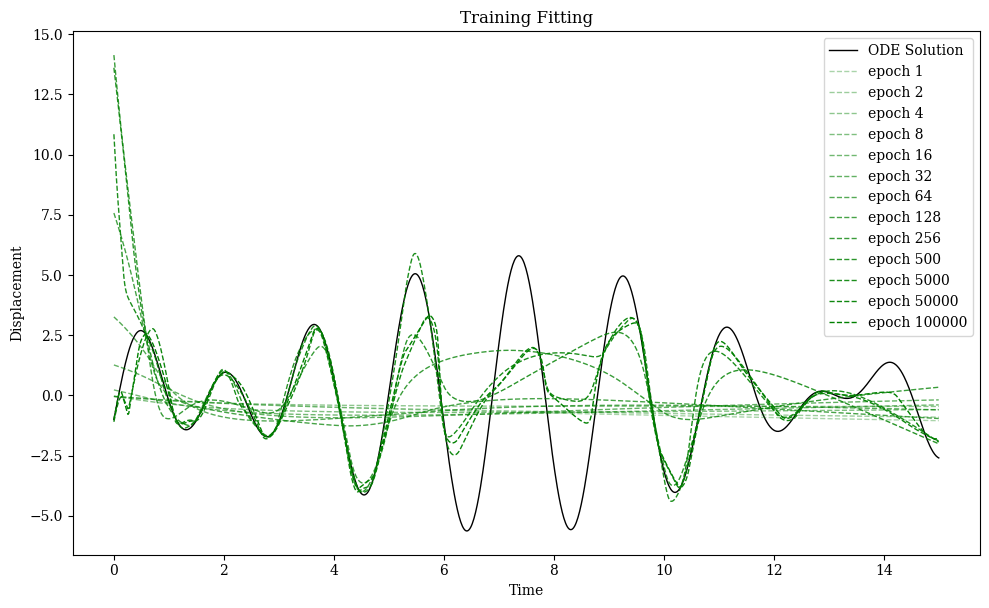

In [20]:
torch.manual_seed(123)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

x_train = torch.tensor(X.query(f"time <= {time_threshold}")["time"].values).float().unsqueeze(1).to(device)
y_train = torch.tensor(X.query(f"time <= {time_threshold}")["displacement"].values).float().unsqueeze(1).to(device)

x_test = torch.tensor(X.query(f"time > {time_threshold}")["time"].values).float().unsqueeze(1).to(device)
y_test = torch.tensor(X.query(f"time > {time_threshold}")["displacement"].values).float().unsqueeze(1).to(device)

hparam_dict = {
    'learning_rate': 1e-3,
    'n_layers': 4,
    'n_neurons': 64,
    'num_epochs': 150000,
 }

learning_rate = hparam_dict["learning_rate"]
num_epochs = hparam_dict["num_epochs"]
architecture = [1] + [hparam_dict["n_neurons"] for _ in range(hparam_dict["n_layers"])] + [1]

plot_loss_train = dict(epoch=[], dataloss=[], physicsloss=[], param_=[])

_locations = torch.linspace(0, 15, 50).view(-1,1).requires_grad_(True).to(device)
_m = torch.tensor(3.21, dtype=torch.float, requires_grad=True, device=device)
_c = torch.tensor(c, dtype=torch.float, requires_grad=False).to(device)
_k = torch.tensor(k, dtype=torch.float, requires_grad=False).to(device)
_w = torch.tensor(w, dtype=torch.float, requires_grad=False).to(device)
_x0 = torch.tensor(x0, dtype=torch.float, requires_grad=False).to(device)
_v0 = torch.tensor(v0, dtype=torch.float, requires_grad=False).to(device)
_phid = torch.tensor(phid, dtype=torch.float, requires_grad=False).to(device)
_F0 = torch.tensor(F0, dtype=torch.float, requires_grad=False, device=device)

model = MultiLayerPerceptronRegressor(architecture, nn.ELU)
model.to(device)
optimizer = optim.Adam([{"params": model.parameters()}, {"params": [_m]}], lr=learning_rate)
criterion = nn.MSELoss()
loss = torch.tensor(1e6, dtype=torch.float, requires_grad=False).to(device)

print(model)

t = np.linspace(0, 15, 1000)
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(10, golden_ratio*10))
ax1.plot(t, driven_oscillator(t, m, k, c, w0, w, F0, x0, v0, phid), label="ODE Solution", c="k", linestyle="-", linewidth=1,)

for epoch in tqdm.tqdm(range(hparam_dict["num_epochs"])):
    if loss.item() > 1e-4 or epoch < 10000:
        optimizer.zero_grad()

        # forward
        y_train_hat = model(x_train)
        data_loss = criterion(y_train_hat, y_train)

        y_location_hat = model(_locations)
        dydt = torch.autograd.grad(y_location_hat, _locations, grad_outputs=torch.ones_like(y_location_hat), create_graph=True)[0]
        dy2dt2 = torch.autograd.grad(dydt, _locations, grad_outputs=torch.ones_like(dydt), create_graph=True)[0]

        _diff_equation = _m*dy2dt2 + _c*dydt + _k*y_location_hat - _F0*torch.cos(_w*_locations-_phid)
        
        if epoch > 7500:
            physics_loss = criterion(_diff_equation, torch.zeros_like(_diff_equation))
            _x0_loss = criterion(y_location_hat[0], _x0)
            _v0_loss = criterion(dydt[0], _v0)
        else:
            physics_loss = torch.tensor(0, dtype=torch.float, requires_grad=False).to(device)
            _x0_loss = torch.tensor(0, dtype=torch.float, requires_grad=False).to(device)
            _v0_loss = torch.tensor(0, dtype=torch.float, requires_grad=False).to(device)

        loss = data_loss + (1e-4)*(physics_loss + _x0_loss + _v0_loss)
        
        # backward
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % 1000 == 0:
            str_epoch = str(epoch+1).zfill(5)
            str_num_epochs = str(num_epochs).zfill(5)
            str_loss = str(round(loss.item(), 4))
            str_physics_loss = str(round(physics_loss.item(), 4))
            # print(f"epoch [{str_epoch}/{str_num_epochs}] loss: {str_loss} physics loss: {str_physics_loss}")
            # print("F0: ", _F0.item())
            print("m: ", _m.item())
            print(f"Data Loss: {data_loss.item():.6f}, Physics Loss: {physics_loss.item():.6f}, x0 Loss: {_x0_loss.item():.6f}, v0 Loss: {_v0_loss.item():.6f}, Total Loss: {loss.item():.6f}")

        if (epoch+1) % 5 == 0:
            plot_loss_train["epoch"].append(epoch+1)
            plot_loss_train["dataloss"].append(data_loss.item())
            plot_loss_train["physicsloss"].append(physics_loss.item())
            # plot_loss_train["param_f0"].append(_F0.item())
            plot_loss_train["param_"].append(_m.item())
        
        _E = [2**0, 2**1, 2**2, 2**3, 2**4, 2**5, 2**6, 2**7, 2**8, 500, 5000, 50000, 100000]
        if (epoch+1) in _E:
            _index = np.where(np.array(_E) == (epoch+1))[0][0]
            model.eval()
            t = np.linspace(0, 15, 1000)
            ax1.plot(
                t, model(torch.tensor(t).float().unsqueeze(1).to(device)).cpu().detach().numpy(), 
                label=f"epoch {epoch+1}", linestyle="--", linewidth=1, c="g", alpha=((_index+1) + 5)/(len(_E) + 5)
            )   

ax1.set_xlabel("Time")
ax1.set_ylabel("Displacement")
ax1.legend()

plt.title("Training Fitting")
plt.tight_layout()

plt.savefig(f"{folder_path}/displacement_vs_time_with_training.png", dpi=300)

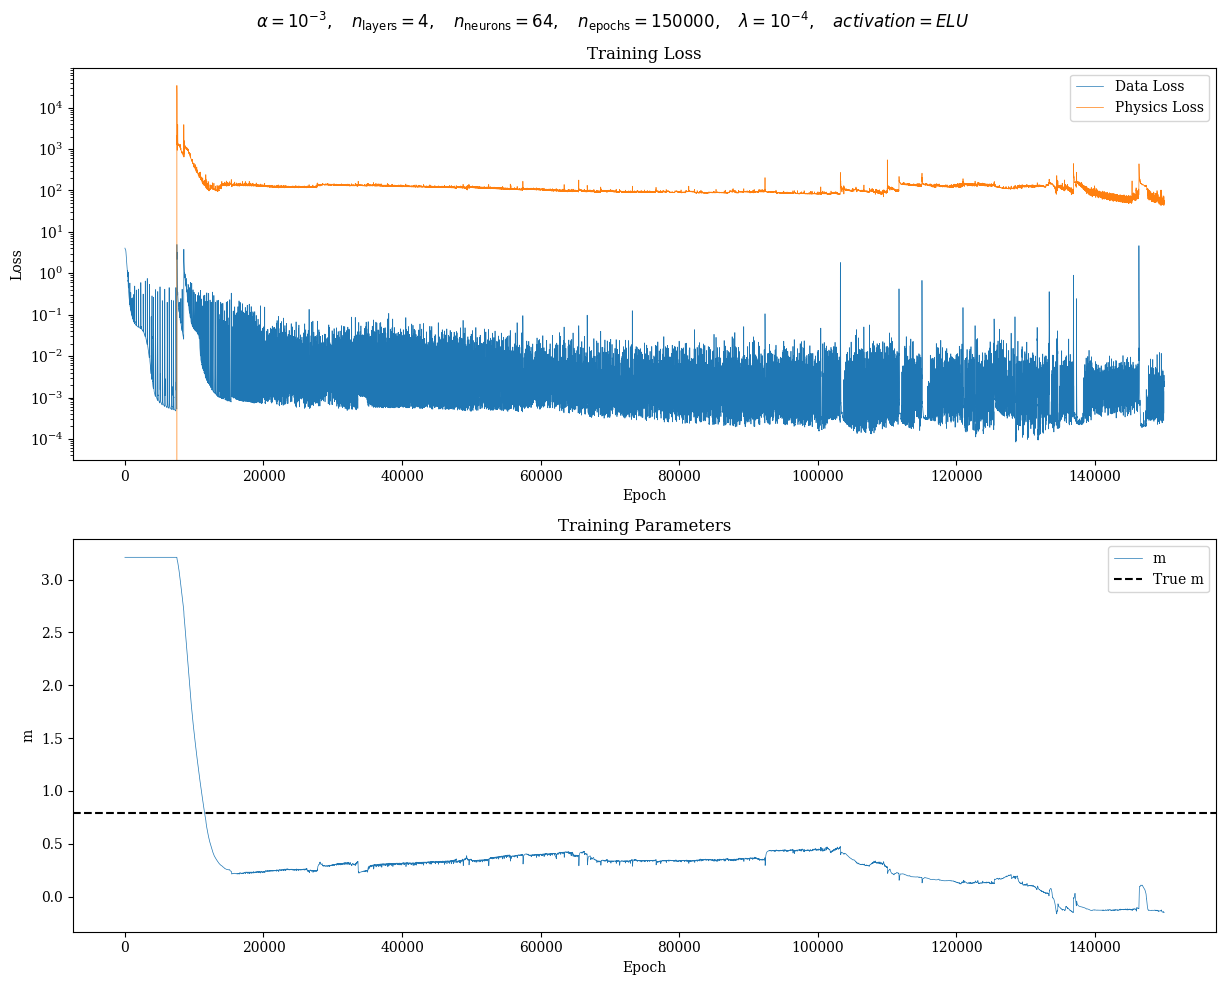

In [27]:
fig, ((ax1, ax2)) = plt.subplots(ncols=1, nrows=2, figsize=(2*golden_ratio*10, 10))

pd.DataFrame(plot_loss_train).plot(x="epoch", y="dataloss",  ax=ax1, label="Data Loss", linewidth=0.5)
pd.DataFrame(plot_loss_train).plot(x="epoch", y="physicsloss", ax=ax1, label="Physics Loss", linewidth=0.5)

pd.DataFrame(plot_loss_train).plot(x="epoch", y="param_", ax=ax2, label="m", linewidth=0.5)
ax2.axhline(y=m, c="k", linestyle="--", label="True m")

ax1.set_xlabel(r"Epoch")
ax1.set_ylabel(r"Loss")
ax1.set_title(r"Training Loss")
ax1.set_yscale('log')
ax1.legend()

ax2.set_xlabel(r"Epoch")
ax2.set_ylabel(r"m")
ax2.set_title(r"Training Parameters")
ax2.legend()

plt.suptitle(r"$\alpha=10^{-3},\quad n_{\text{layers}}=4,\quad n_{\text{neurons}}=64, \quad n_{\text{epochs}}=150000, \quad \lambda=10^{-4}, \quad activation=ELU$")
plt.tight_layout()
plt.savefig(f"{folder_path}/training_loss.png", dpi=300)

pd.DataFrame(x_train.cpu().numpy(), columns=["time"]).to_parquet(f"{folder_path}/x_train.parquet")
pd.DataFrame(y_train.cpu().numpy(), columns=["temperature"]).to_parquet(f"{folder_path}/y_train.parquet")

torch.save(model, f"{folder_path}/pinn_model.pth")
torch.save(model.state_dict(), f"{folder_path}/pinn_weights.pth")

.